# PSET 4 — Model-base Control

**Due date: November 30th, 11:59 pm**

This is the last problem set and we will cover topics from LQR control to trajectory optimization and model predictive control. You will learn how to write python code to solve a trajectory when given dynamics using numerical solver.

Problem 1 - Linear system with bounded control (25pt + 10pt bonus)
- 1.1 Prove convexity (5pt)
- 1.2 Discretization of dynamics (5pt)
- 1.3 Numerical solve trajectory optimization (10pt)
- 1.4 Resolution study (5pt)
- 1.5 KKT system (Bonus) (10pt)

Problem 2 - Use linearized dynamics to design a LQR controller (25pt + 5pt bonus)
- 2.1 Lagrangian dynamics (Bonus) (5pt)
- 2.2 State space dynamics (5pt)
- 2.3 Linearize dynamics (5pt)
- 2.4 Simulate error (5pt)
- 2.5 LQR controller (10pt)

Problem 3 - Solve obstacle avoidance problem using CRISP solver (20pt)
- 3.1 Write down the problem (10pt)
- 3.2 Solve the problem using CRISP (10pt)

Problem 4 - Model predictive control on Inverted pendulum (30pt)
- 4.1 Trajectory optimization (10pt)
- 4.2 Fail of open loop control (10pt)
- 4.3 MPC control (10pt)


## Problem 1— LQR with bounded control

In class, we studied the unconstrained LQR problem solved via Bellman’s equation. In practice, inputs and states are rarely unbounded—actuators saturate and safety limits constrain the state.

For linear systems with convex constraints on inputs and states, the seminal paper [Bemporad et al., 2002](http://cse.lab.imtlucca.it/~bemporad/publications/papers/automatica-mpqp.pdf) analyzes the structure of the optimal cost-to-go (value function) and controller. We consider a finite-horizon, discrete-time linear system with fixed matrices $A, B$, deterministic dynamics, and a quadratic cost. Inputs are **bounded**.

Given $x_0$, horizon $N$, weights $Q_k \succeq 0$ for $k=0,\dots,N$ and $R_k \succ 0$ for $k=0,\dots,N-1$, and a bound $u_{\max} > 0$, consider
$$
\begin{aligned}
J(x_0) \;=\; \min_{u_0,\dots,u_{N-1}} \;&
\sum_{k=0}^{N} x_k^\top Q_k x_k \;+\; \sum_{k=0}^{N-1} u_k^\top R_k u_k \\
\text{s.t.}\;& x_{k+1} = A x_k + B u_k,\quad k=0,\dots,N-1,\\
& u_k \in [-u_{\max},\, u_{\max}] \ \text{(componentwise)},\quad k=0,\dots,N-1.
\end{aligned}
$$




### 1.1. **Convexity.** 
Show the problem is a convex optimization problem when $x_0$ is fixed.

**Answer:**

When $x_0$ is fixed, the only decision variables are the controls $u_0, \ldots, u_{N-1}$. From the dynamics $x_{k+1} = Ax_k + Bu_k$, we can recursively expand each state:
$$x_1 = Ax_0 + Bu_0, \quad x_2 = A^2x_0 + ABu_0 + Bu_1, \quad \ldots$$
In general, $x_k = A^k x_0 + \sum_{j=0}^{k-1} A^{k-1-j} B u_j$. Since $x_0$ is fixed, each $x_k$ is just an affine function of the controls (linear in $u_j$ plus a constant term $A^k x_0$).

Now consider the objective $J = \sum_{k=0}^{N} x_k^\top Q_k x_k + \sum_{k=0}^{N-1} u_k^\top R_k u_k$. The control terms $u_k^\top R_k u_k$ are convex quadratics since $R_k \succ 0$. For the state terms, since $x_k$ is affine in the controls, we can write $x_k = C_k \mathbf{u} + d_k$ for some matrix $C_k$ and constant $d_k$. Then $x_k^\top Q_k x_k = (C_k \mathbf{u} + d_k)^\top Q_k (C_k \mathbf{u} + d_k)$, which is a convex quadratic in $\mathbf{u}$ because $Q_k \succeq 0$ and composing a convex quadratic form with an affine map preserves convexity. Since the sum of convex functions is convex, the entire objective is convex.

For the constraints: the dynamics are linear equalities (automatically satisfied by our parameterization), and the control bounds $u_k \in [-u_{\max}, u_{\max}]$ are just box constraints, which form a convex polyhedron. The intersection of these is convex.

Thus the problem is a convex QP. QED.



### 1.2. Double integrator discretization

Start from the continuous-time model $\ddot q = u,\ u \in [-1,1]$. Using $x=[q,\ \dot q]^\top$ and a fixed time step $dt$, derive the discrete system $x_{k+1} = A x_k + B u_k$.

**Answer:**  

The double integrator $\ddot{q} = u$ can be written in first-order form by letting $x = [q, \dot{q}]^\top$. Then $\dot{x}_1 = x_2$ and $\dot{x}_2 = u$, which gives the continuous-time state-space model:
$$\dot{x} = \begin{bmatrix} 0 & 1 \\ 0 & 0 \end{bmatrix} x + \begin{bmatrix} 0 \\ 1 \end{bmatrix} u = A_c x + B_c u$$

Using forward Euler discretization with timestep $dt$, we approximate $\dot{x} \approx \frac{x_{k+1} - x_k}{dt}$, so $x_{k+1} = x_k + dt \cdot \dot{x}_k = (I + dt \cdot A_c)x_k + dt \cdot B_c u_k$. This gives:
$$\boxed{A = \begin{bmatrix} 1 & dt \\ 0 & 1 \end{bmatrix}, \quad B = \begin{bmatrix} 0 \\ dt \end{bmatrix}}$$

So the discrete system is $x_{k+1} = Ax_k + Bu_k$, i.e., $q_{k+1} = q_k + dt \cdot \dot{q}_k$ and $\dot{q}_{k+1} = \dot{q}_k + dt \cdot u_k$.



### 1.3 Numerical exploration

With $N=50$, $dt=0.1$, and your choice of $Q_k, R_k$, solve the problem for a grid of initial states $x_0$ (using cvxpy). Plot $J(x_0)$ and a representative control (e.g., $u_0(x_0)$).


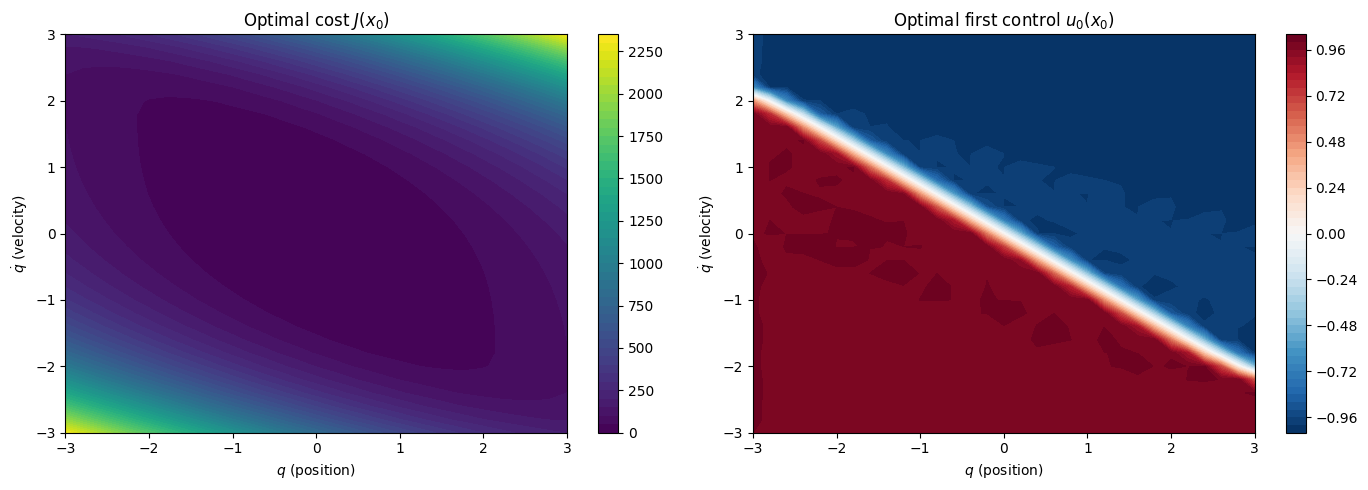

In [1]:
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

# =========================
# Problem setup
# =========================

####################
# TODO: Define the hyperparameters
####################
N   = 50
dt  = 0.1
umax = 1.0

# Euler discretization for the double integrator: x = [q, qdot]
A = np.array([[1, dt],
              [0, 1]])
B = np.array([[0],
              [dt]])

# Cost weights (time-invariant)
Q  = np.eye(2)       # penalize position and velocity equally
R  = np.array([[0.1]])  # small penalty on control effort

n, m = A.shape[0], B.shape[1]

# =========================
# Build one QP (with Parameter x0) that we can reuse for all grid points
# =========================

####################
# TODO: Define problem using cvxpy
####################

x0_param = cp.Parameter(n)  # initial condition parameter

# Decision variables
x = cp.Variable((n, N+1))  # states x_0, ..., x_N
u = cp.Variable((m, N))    # controls u_0, ..., u_{N-1}

# Objective: sum of x'Qx + u'Ru
cost = 0
for k in range(N+1):
    cost += cp.quad_form(x[:, k], Q)
for k in range(N):
    cost += cp.quad_form(u[:, k], R)

# Constraints
constraints = [x[:, 0] == x0_param]  # initial condition
for k in range(N):
    constraints += [x[:, k+1] == A @ x[:, k] + B @ u[:, k]]  # dynamics
    constraints += [u[:, k] >= -umax, u[:, k] <= umax]       # control bounds

prob = cp.Problem(cp.Minimize(cost), constraints)

# =========================
# Grid of initial states
# =========================

####################
# TODO: Plot here
####################

# Create grid of initial states
n_grid = 31
q_vals = np.linspace(-3, 3, n_grid)
qdot_vals = np.linspace(-3, 3, n_grid)
Q_grid, Qdot_grid = np.meshgrid(q_vals, qdot_vals)

J_grid = np.zeros((n_grid, n_grid))
u0_grid = np.zeros((n_grid, n_grid))

# Solve for each initial condition
for i in range(n_grid):
    for j in range(n_grid):
        x0_param.value = np.array([Q_grid[i, j], Qdot_grid[i, j]])
        prob.solve(solver=cp.OSQP, warm_start=True)
        if prob.status == 'optimal':
            J_grid[i, j] = prob.value
            u0_grid[i, j] = u.value[0, 0]
        else:
            J_grid[i, j] = np.nan
            u0_grid[i, j] = np.nan

# Plot J(x0)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

c1 = axes[0].contourf(Q_grid, Qdot_grid, J_grid, levels=50, cmap='viridis')
axes[0].set_xlabel('$q$ (position)')
axes[0].set_ylabel('$\dot{q}$ (velocity)')
axes[0].set_title('Optimal cost $J(x_0)$')
plt.colorbar(c1, ax=axes[0])

# Plot u_0(x0)
c2 = axes[1].contourf(Q_grid, Qdot_grid, u0_grid, levels=50, cmap='RdBu_r')
axes[1].set_xlabel('$q$ (position)')
axes[1].set_ylabel('$\dot{q}$ (velocity)')
axes[1].set_title('Optimal first control $u_0(x_0)$')
plt.colorbar(c2, ax=axes[1])

plt.tight_layout()
plt.show()




### 1.4 Resolution study

Increase $N$, decrease $dt$, and plot $J,u$ on a denser grid of initial states. What can you observe from the plots? Comment on solver runtime.

**Answer:**

See the code and plots below. Key observations:

1. **Cost $J(x_0)$**: The overall shape remains similar—smooth, tilted elliptical contours centered near the origin where the system is already at rest. However, the high-resolution case ($N=100$, $dt=0.05$) shows costs roughly twice as large (~4500 vs ~2250). This is because with twice as many timesteps, the running cost $\sum_k x_k^\top Q x_k + u_k^\top R u_k$ accumulates over more terms. The contour shape is essentially identical, confirming convergence of the policy as discretization refines.

2. **Control $u_0(x_0)$**: Both cases exhibit clear bang-bang behavior—the control saturates at $\pm u_{\max}$ almost everywhere. The switching boundary follows roughly $q + \dot{q} \approx 0$, which makes physical sense: if position plus velocity is positive, brake ($u < 0$); if negative, accelerate ($u > 0$). The high-resolution plot shows a slightly sharper transition band along this switching curve.

3. **Solver runtime**: With $N=100$ (vs 50) and a $51 \times 51$ grid (vs $31 \times 31$), we solve 2601 QPs taking ~17.4s total (~6.7ms per solve). This is significantly slower than the original case. The cost scales with both problem size (more variables/constraints per QP) and grid density (more QPs to solve). Warm-starting helps keep per-solve time reasonable.


High resolution: N=100, dt=0.05, grid=51x51
Total solves: 2601, Time: 17.40s
Average time per solve: 6.69 ms


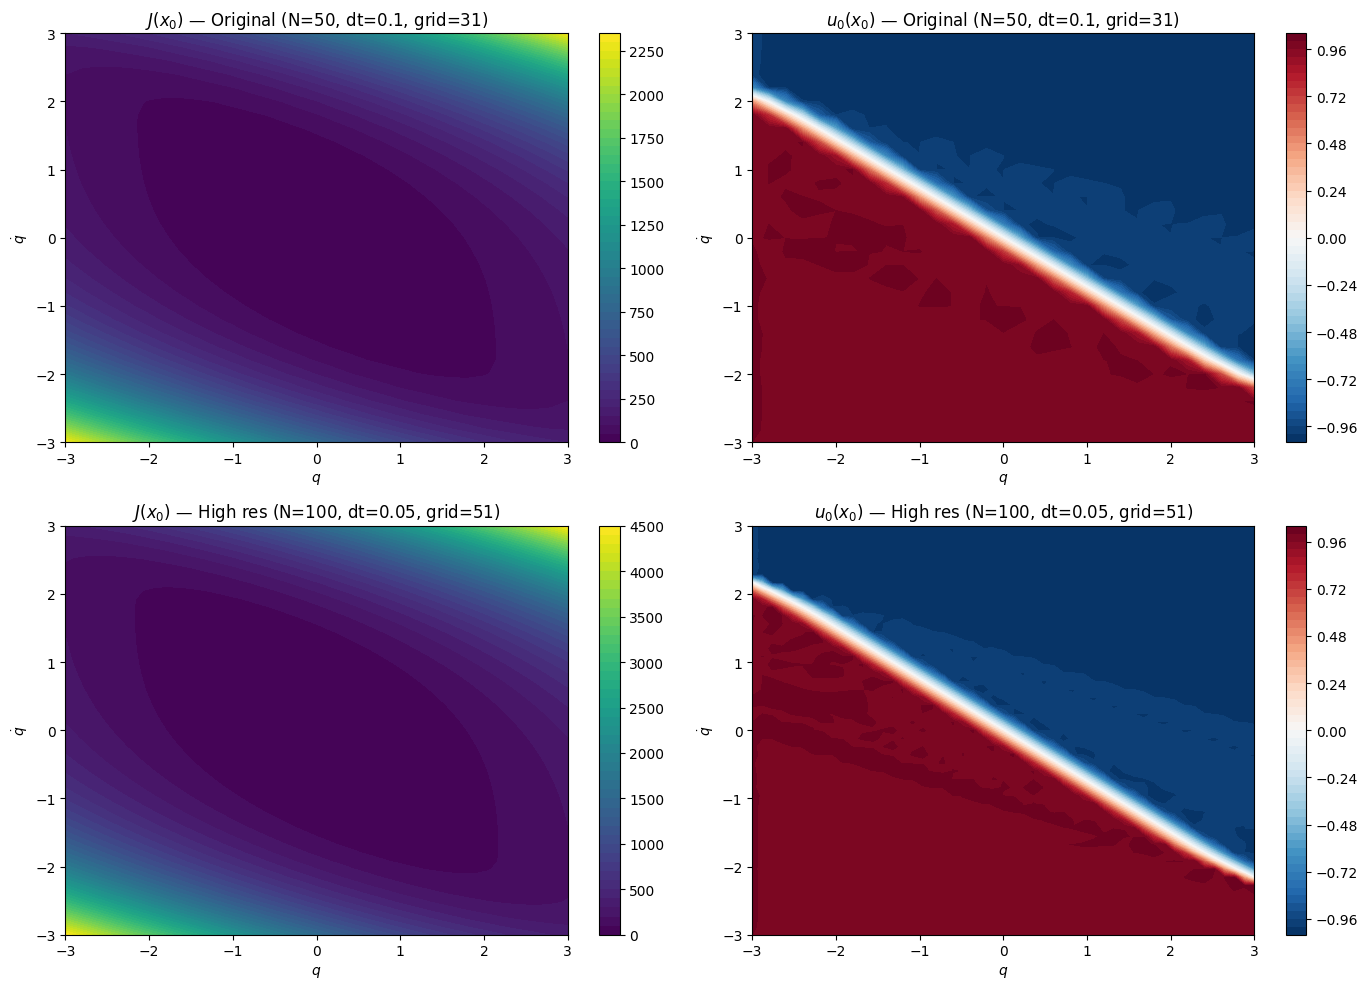

In [2]:
import time

# =========================
# Resolution study: increase N, decrease dt, denser grid
# =========================

# Higher resolution parameters
N_high = 100       # doubled from 50
dt_high = 0.05     # halved from 0.1 (same total horizon T = 5s)
n_grid_high = 51   # denser grid (was 31)

# Rebuild A, B for new dt
A_high = np.array([[1, dt_high],
                   [0, 1]])
B_high = np.array([[0],
                   [dt_high]])

# Build new problem
x0_param_high = cp.Parameter(n)
x_high = cp.Variable((n, N_high+1))
u_high = cp.Variable((m, N_high))

cost_high = 0
for k in range(N_high+1):
    cost_high += cp.quad_form(x_high[:, k], Q)
for k in range(N_high):
    cost_high += cp.quad_form(u_high[:, k], R)

constraints_high = [x_high[:, 0] == x0_param_high]
for k in range(N_high):
    constraints_high += [x_high[:, k+1] == A_high @ x_high[:, k] + B_high @ u_high[:, k]]
    constraints_high += [u_high[:, k] >= -umax, u_high[:, k] <= umax]

prob_high = cp.Problem(cp.Minimize(cost_high), constraints_high)

# Create denser grid
q_vals_high = np.linspace(-3, 3, n_grid_high)
qdot_vals_high = np.linspace(-3, 3, n_grid_high)
Q_grid_high, Qdot_grid_high = np.meshgrid(q_vals_high, qdot_vals_high)

J_grid_high = np.zeros((n_grid_high, n_grid_high))
u0_grid_high = np.zeros((n_grid_high, n_grid_high))

# Solve and time it
start_time = time.time()
for i in range(n_grid_high):
    for j in range(n_grid_high):
        x0_param_high.value = np.array([Q_grid_high[i, j], Qdot_grid_high[i, j]])
        prob_high.solve(solver=cp.OSQP, warm_start=True)
        if prob_high.status == 'optimal':
            J_grid_high[i, j] = prob_high.value
            u0_grid_high[i, j] = u_high.value[0, 0]
        else:
            J_grid_high[i, j] = np.nan
            u0_grid_high[i, j] = np.nan
elapsed_high = time.time() - start_time

print(f"High resolution: N={N_high}, dt={dt_high}, grid={n_grid_high}x{n_grid_high}")
print(f"Total solves: {n_grid_high**2}, Time: {elapsed_high:.2f}s")
print(f"Average time per solve: {elapsed_high / n_grid_high**2 * 1000:.2f} ms")

# Plot comparison
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Original (from 1.3)
c1 = axes[0, 0].contourf(Q_grid, Qdot_grid, J_grid, levels=50, cmap='viridis')
axes[0, 0].set_xlabel('$q$'); axes[0, 0].set_ylabel('$\dot{q}$')
axes[0, 0].set_title(f'$J(x_0)$ — Original (N={N}, dt={dt}, grid={n_grid})')
plt.colorbar(c1, ax=axes[0, 0])

c2 = axes[0, 1].contourf(Q_grid, Qdot_grid, u0_grid, levels=50, cmap='RdBu_r')
axes[0, 1].set_xlabel('$q$'); axes[0, 1].set_ylabel('$\dot{q}$')
axes[0, 1].set_title(f'$u_0(x_0)$ — Original (N={N}, dt={dt}, grid={n_grid})')
plt.colorbar(c2, ax=axes[0, 1])

# High resolution
c3 = axes[1, 0].contourf(Q_grid_high, Qdot_grid_high, J_grid_high, levels=50, cmap='viridis')
axes[1, 0].set_xlabel('$q$'); axes[1, 0].set_ylabel('$\dot{q}$')
axes[1, 0].set_title(f'$J(x_0)$ — High res (N={N_high}, dt={dt_high}, grid={n_grid_high})')
plt.colorbar(c3, ax=axes[1, 0])

c4 = axes[1, 1].contourf(Q_grid_high, Qdot_grid_high, u0_grid_high, levels=50, cmap='RdBu_r')
axes[1, 1].set_xlabel('$q$'); axes[1, 1].set_ylabel('$\dot{q}$')
axes[1, 1].set_title(f'$u_0(x_0)$ — High res (N={N_high}, dt={dt_high}, grid={n_grid_high})')
plt.colorbar(c4, ax=axes[1, 1])

plt.tight_layout()
plt.show()




### 1.5 KKT conditions (Bonus)
Write the KKT optimality conditions for the problem.

**Answer:**  

We form the Lagrangian by introducing dual variables: $\lambda_k \in \mathbb{R}^n$ for the dynamics constraints ($k=1,\ldots,N$), and $\mu_k^+, \mu_k^- \in \mathbb{R}^m$ for the upper/lower control bounds ($k=0,\ldots,N-1$). Writing the inequality constraints as $u_k - u_{\max} \leq 0$ and $-u_k - u_{\max} \leq 0$:

$$\mathcal{L} = \sum_{k=0}^{N} x_k^\top Q_k x_k + \sum_{k=0}^{N-1} u_k^\top R_k u_k + \sum_{k=0}^{N-1} \lambda_{k+1}^\top (Ax_k + Bu_k - x_{k+1}) + \sum_{k=0}^{N-1} (\mu_k^+)^\top(u_k - u_{\max}) + \sum_{k=0}^{N-1} (\mu_k^-)^\top(-u_k - u_{\max})$$

The KKT conditions are:

**1. Stationarity** ($\nabla \mathcal{L} = 0$ w.r.t. primal variables):

For states $x_k$, $k=1,\ldots,N-1$:
$$\boxed{2Q_k x_k + A^\top \lambda_{k+1} - \lambda_k = 0}$$

For terminal state $x_N$:
$$\boxed{2Q_N x_N - \lambda_N = 0}$$

For controls $u_k$, $k=0,\ldots,N-1$:
$$\boxed{2R_k u_k + B^\top \lambda_{k+1} + \mu_k^+ - \mu_k^- = 0}$$

**2. Primal feasibility:**
$$x_{k+1} = Ax_k + Bu_k, \quad k=0,\ldots,N-1$$
$$-u_{\max} \leq u_k \leq u_{\max}, \quad k=0,\ldots,N-1$$

**3. Dual feasibility:**
$$\mu_k^+ \geq 0, \quad \mu_k^- \geq 0, \quad k=0,\ldots,N-1$$

**4. Complementary slackness:**
$$\mu_k^+ \odot (u_k - u_{\max}) = 0, \quad k=0,\ldots,N-1$$
$$\mu_k^- \odot (-u_k - u_{\max}) = 0, \quad k=0,\ldots,N-1$$

where $\odot$ denotes componentwise multiplication. The stationarity conditions for $x_k$ can be interpreted as a backward recursion for the co-state $\lambda_k$ (similar to the adjoint equation in Pontryagin's principle). The control optimality condition shows that $u_k$ balances the gradient of the running cost ($2R_k u_k$) against the co-state feedback ($B^\top \lambda_{k+1}$), with the multipliers $\mu_k^\pm$ activating when the control saturates at the bounds.


## Problem 2 — Cart–Pole system (linearization + LQR)

We consider a cart of mass $m_c$ moving on a horizontal track with a pendulum (mass $m_p$, length $l$) hinged to the cart. The input $f$ is a horizontal force applied to the cart. We assume no friction and model the pendulum as a point mass at its tip. See the [Video](https://www.youtube.com/watch?v=Bzq96V1yN5k).

<figure style="text-align:center;">
  <img src="https://raw.githubusercontent.com/ComputationalRobotics/2025-ES-AM-158-PSET/main/PSET4/cartpole.png" width="360" alt="Inscribed polygon">
  <figcaption style="color:#6a737d; font-style:italic;">
    Figure 1. Cartpole.
  </figcaption>
</figure>

With this setup, we parameterize the system by two scalars: $x$ denotes the cart position, and $\theta$ is the angle between the pole and the stable equilibrium. Our goal is to study the cart–pole dynamics under the horizontal control force $f$.




### 2.1 Lagrangian derivation (Bonus)
For those of you who have background in rigid-body dynamics, this is an opportunity for you to apply your knowledge. However, feel free to skip this subproblem and it won’t affect the rest of the exercise. Derive the equations of motion:

$$
\begin{aligned}
(m_c + m_p)\,\ddot{x} + m_p\,l\,\ddot{\theta}\cos\theta - m_p\,l\,\dot{\theta}^2\sin\theta &= f, \\ 
m_p\,l\,\ddot{x}\cos\theta + m_p\,l^2\,\ddot{\theta} + m_p\,g\,l\,\sin\theta &= 0.
\end{aligned}
$$
(Hints: compute the Lagrangian of the system and the corresponding Lagrangian equations. Analyzing the two objects separately also works.)

**Answer:**

Let $\theta$ be measured from the downward stable equilibrium. The pendulum tip position is $(x + l\sin\theta, -l\cos\theta)$ relative to the cart pivot, so its velocity is $(\dot{x} + l\dot{\theta}\cos\theta, l\dot{\theta}\sin\theta)$.

The kinetic energy is:
$$T = \frac{1}{2}m_c\dot{x}^2 + \frac{1}{2}m_p\left[(\dot{x} + l\dot{\theta}\cos\theta)^2 + (l\dot{\theta}\sin\theta)^2\right]$$
Expanding: $T = \frac{1}{2}(m_c + m_p)\dot{x}^2 + m_p l\dot{x}\dot{\theta}\cos\theta + \frac{1}{2}m_p l^2\dot{\theta}^2$

The potential energy (with $y=0$ at the pivot) is $V = -m_p g l\cos\theta$.

So the Lagrangian is:
$$L = T - V = \frac{1}{2}(m_c + m_p)\dot{x}^2 + m_p l\dot{x}\dot{\theta}\cos\theta + \frac{1}{2}m_p l^2\dot{\theta}^2 + m_p g l\cos\theta$$

Applying Euler-Lagrange for $x$ (with external force $f$): $\frac{d}{dt}\frac{\partial L}{\partial \dot{x}} - \frac{\partial L}{\partial x} = f$

We have $\frac{\partial L}{\partial \dot{x}} = (m_c + m_p)\dot{x} + m_p l\dot{\theta}\cos\theta$, and $\frac{\partial L}{\partial x} = 0$. Taking the time derivative:
$$\boxed{(m_c + m_p)\ddot{x} + m_p l\ddot{\theta}\cos\theta - m_p l\dot{\theta}^2\sin\theta = f}$$

Applying Euler-Lagrange for $\theta$: $\frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}} - \frac{\partial L}{\partial \theta} = 0$

We have $\frac{\partial L}{\partial \dot{\theta}} = m_p l\dot{x}\cos\theta + m_p l^2\dot{\theta}$ and $\frac{\partial L}{\partial \theta} = -m_p l\dot{x}\dot{\theta}\sin\theta - m_p g l\sin\theta$.

Taking the time derivative: $\frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}} = m_p l\ddot{x}\cos\theta - m_p l\dot{x}\dot{\theta}\sin\theta + m_p l^2\ddot{\theta}$

Subtracting $\frac{\partial L}{\partial \theta}$, the $m_p l\dot{x}\dot{\theta}\sin\theta$ terms cancel, leaving:
$$\boxed{m_p l\ddot{x}\cos\theta + m_p l^2\ddot{\theta} + m_p g l\sin\theta = 0}$$


### 2.2 State–space form.
Let $x_1=x$, $x_2=\theta$, $x_3=\dot x$, $x_4=\dot\theta$, and input $u=f$. Translate the equations in 2.1 into the basic state-space dynamics form $\dot{\mathbf x}=F(\mathbf x,u)$.

**Answer:**  

The first two state derivatives are trivial: $\dot{x}_1 = x_3$ and $\dot{x}_2 = x_4$. For $\dot{x}_3 = \ddot{x}$ and $\dot{x}_4 = \ddot{\theta}$, we need to solve the coupled equations from 2.1. Rewriting them as a linear system in $[\ddot{x}, \ddot{\theta}]^\top$:

$$\begin{bmatrix} m_c + m_p & m_p l\cos\theta \\ m_p l\cos\theta & m_p l^2 \end{bmatrix} \begin{bmatrix} \ddot{x} \\ \ddot{\theta} \end{bmatrix} = \begin{bmatrix} u + m_p l\dot{\theta}^2\sin\theta \\ -m_p g l\sin\theta \end{bmatrix}$$

The mass matrix $M(\theta)$ has determinant $\det(M) = m_p l^2(m_c + m_p\sin^2\theta)$. Letting $D = m_c + m_p\sin^2\theta > 0$, we invert and solve:

$$\ddot{x} = \frac{u + m_p\sin\theta\left(l\dot{\theta}^2 + g\cos\theta\right)}{D}$$

$$\ddot{\theta} = \frac{-(m_c + m_p)g\sin\theta - \cos\theta\left(u + m_p l\dot{\theta}^2\sin\theta\right)}{lD}$$

So the state-space form is:

$$\boxed{F(\mathbf{x}, u) = \begin{bmatrix} x_3 \\ x_4 \\ \frac{u + m_p\sin x_2\left(l x_4^2 + g\cos x_2\right)}{m_c + m_p\sin^2 x_2} \\ \frac{-(m_c + m_p)g\sin x_2 - \cos x_2\left(u + m_p l x_4^2\sin x_2\right)}{l(m_c + m_p\sin^2 x_2)} \end{bmatrix}}$$


### 2.3 Linearize about the upright equilibrium. 
Linearize around the unstable equilibrium point $x^*=0$, $\dot x^*=0$, $\theta^*=\pi$, $\dot\theta^*=0$, $u^*=0$  (i.e., the pole is in the upright position and the cart stay at zero.) to obtain $\dot{\Delta x}=A\,\Delta x+B\,\Delta u$ with $\Delta x=x-x^*$, $\Delta u=u-u^*$. Write down what is $A$ and $B$.

**Answer:**  

The linearized system is $\dot{\Delta \mathbf{x}} = A \Delta \mathbf{x} + B \Delta u$ where $A = \frac{\partial F}{\partial \mathbf{x}}\big|_{(\mathbf{x}^*, u^*)}$ and $B = \frac{\partial F}{\partial u}\big|_{(\mathbf{x}^*, u^*)}$.

At the equilibrium $\theta^* = \pi$: $\sin\pi = 0$, $\cos\pi = -1$, and $\dot{\theta}^* = 0$, $u^* = 0$.

From 2.2, define $D = m_c + m_p\sin^2\theta$. At equilibrium, $D|_* = m_c$.

For $F_1 = x_3$ and $F_2 = x_4$, the derivatives are trivial. For $F_3$ (the $\ddot{x}$ equation) and $F_4$ (the $\ddot{\theta}$ equation), we compute partial derivatives and evaluate at equilibrium.

**Key derivatives at equilibrium:**

$\frac{\partial F_3}{\partial \theta}\bigg|_* = \frac{m_p g}{m_c}$ (from $\frac{\partial}{\partial\theta}[m_p\sin\theta(l\dot{\theta}^2 + g\cos\theta)]$ at $\theta=\pi$, $\dot{\theta}=0$)

$\frac{\partial F_3}{\partial u}\bigg|_* = \frac{1}{m_c}$

$\frac{\partial F_4}{\partial \theta}\bigg|_* = \frac{(m_c + m_p)g}{lm_c}$ (from $\frac{\partial}{\partial\theta}[-(m_c+m_p)g\sin\theta]$ at $\theta=\pi$)

$\frac{\partial F_4}{\partial u}\bigg|_* = \frac{1}{lm_c}$ (from $-\cos\theta/lD$ at $\theta=\pi$)

All derivatives w.r.t. $\dot{\theta}$ vanish at equilibrium since they involve $\dot{\theta}$ as a factor.

$$\boxed{A = \begin{bmatrix} 0 & 0 & 1 & 0 \\ 0 & 0 & 0 & 1 \\ 0 & \frac{m_p g}{m_c} & 0 & 0 \\ 0 & \frac{(m_c + m_p)g}{lm_c} & 0 & 0 \end{bmatrix}, \quad B = \begin{bmatrix} 0 \\ 0 \\ \frac{1}{m_c} \\ \frac{1}{lm_c} \end{bmatrix}}$$

The positive entries in the $(3,2)$ and $(4,2)$ positions of $A$ confirm that the upright equilibrium is unstable: a small deviation in $\theta$ from $\pi$ causes both the cart and pole to accelerate in the direction of the tilt.


### 2.4 Linearization Error

Define the linearization error
$e(\mathbf{x}, \mathbf{u}) = \|\,F(\mathbf{x}, \mathbf{u}) - (A\,\Delta\mathbf{x} + B\,\Delta\mathbf{u})\,\|^2$ (i.e., the error between the true nonlinear system and the linearized system).
Simulate both the nonlinear system and its linearization from several initial conditions, and plot how this error evolves over time.

**Simulation**

A minimal forward–Euler loop is:

```
for i in range(100):
    x = x + dt * F(x,u)
```

But here we use the [Runge-Kutta](https://en.wikipedia.org/wiki/Runge–Kutta_methods) format.
```
for i in range(100):
    x = RK4(F(as a handle), x, u, dt)
```

See the provided `rk4_step(f, x, u, dt)` function for details.

**TODO:** Finish the code block.

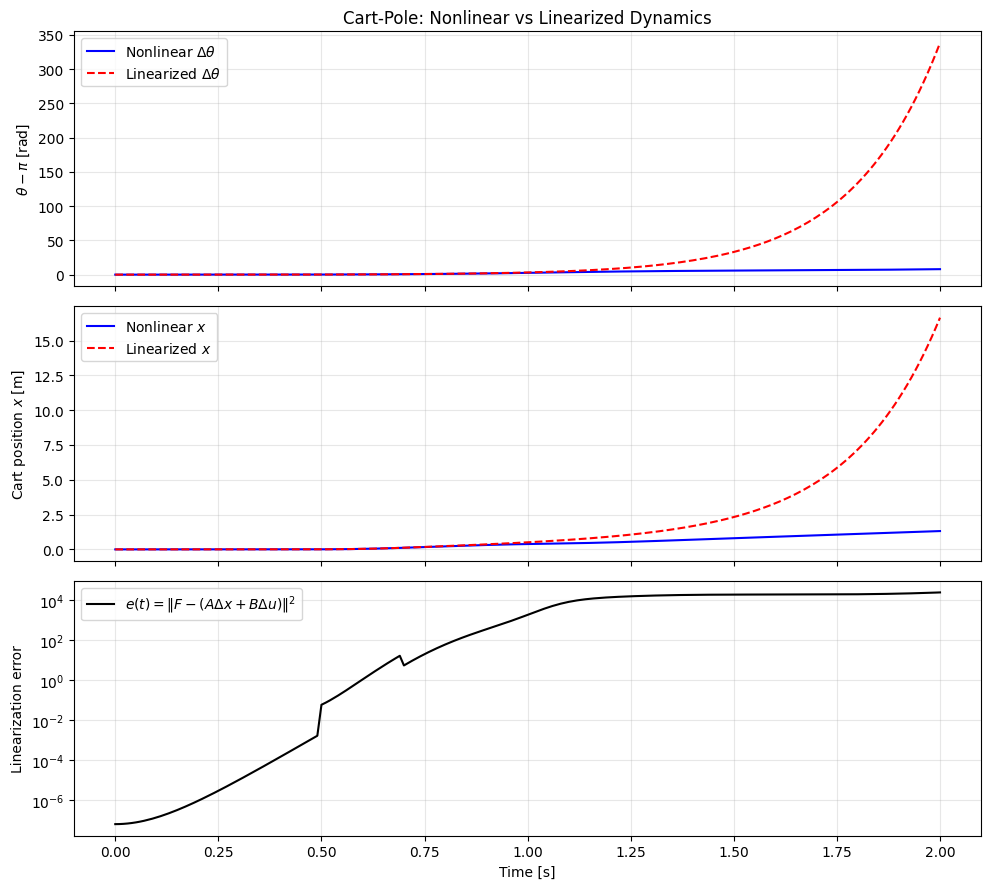

In [3]:
# Cart-pole: simulate nonlinear vs. linearized model and plot linearization error.
# Requirements: numpy, matplotlib

import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Physical parameters (edit if needed)
# -----------------------------
m_c = 1.0   # cart mass [kg]
m_p = 0.1   # pole mass [kg]
l   = 0.5   # pole length [m]
g   = 9.81  # gravity [m/s^2]

# Upright equilibrium (x*, theta*, xdot*, thetadot*, u*)
x_star = np.array([0.0, np.pi, 0.0, 0.0])
u_star = np.array([0.0])

# -----------------------------
# Dynamics
# -----------------------------
def F(x, u):
    """
    Nonlinear cart-pole dynamics: x=[x, theta, xdot, thetadot]
    returns [xdot, thetadot, xddot, thetaddot]
    """
    _, theta, x_dot, theta_dot = x
    u_val = u[0] if hasattr(u, '__len__') else u
    
    sin_th = np.sin(theta)
    cos_th = np.cos(theta)
    D = m_c + m_p * sin_th**2
    
    x_ddot = (u_val + m_p * sin_th * (l * theta_dot**2 + g * cos_th)) / D
    theta_ddot = (-(m_c + m_p) * g * sin_th - cos_th * (u_val + m_p * l * theta_dot**2 * sin_th)) / (l * D)
    
    return np.array([x_dot, theta_dot, x_ddot, theta_ddot])


def F_lin_state(x, u):
    """
    Linearized dynamics about (x_star, u_star):
        xdot ≈ A (x - x_star) + B (u - u_star)
    using the provided A and B matrices.
    """
    # A and B matrices from 2.3
    A = np.array([
        [0, 0, 1, 0],
        [0, 0, 0, 1],
        [0, m_p * g / m_c, 0, 0],
        [0, (m_c + m_p) * g / (l * m_c), 0, 0]
    ])
    B = np.array([0, 0, 1/m_c, 1/(l * m_c)])
    
    u_val = u[0] if hasattr(u, '__len__') else u
    delta_x = x - x_star
    delta_u = u_val - u_star[0]
    
    return A @ delta_x + B * delta_u


# -----------------------------
# Integrator (RK4)
# -----------------------------
def rk4_step(f, x, u, dt):
    k1 = f(x, u)
    k2 = f(x + 0.5*dt*k1, u)
    k3 = f(x + 0.5*dt*k2, u)
    k4 = f(x + dt*k3, u)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)


# -----------------------------
# Input profiles (edit or add your own)
# -----------------------------
def make_u_fun(kind="zero", amp=5.0, t0=0.5, width=0.2, freq=1.0):
    """
    kind: "zero" | "step" | "pulse" | "sine"
    amp:  amplitude (N)
    t0:   step/pulse start (s)
    width:pulse width (s)
    freq: sine frequency (Hz)
    """
    if kind == "zero":
        return lambda t, x: 0.0
    if kind == "step":
        return lambda t, x: (amp if t >= t0 else 0.0)
    if kind == "pulse":
        return lambda t, x: (amp if (t0 <= t <= t0+width) else 0.0)
    if kind == "sine":
        return lambda t, x: amp*np.sin(2*np.pi*freq*t)
    raise ValueError("unknown kind")


# -----------------------------
# Simulation
# -----------------------------
def simulate_cartpole_error(x0, T=5.0, dt=0.01, u_kind="zero", **u_kwargs):
    """
    Simulate nonlinear and linearized models from initial state x0.
    Returns dict with time, states, and error e(t).
    """
    u_fun = make_u_fun(u_kind, **u_kwargs)

    ts = np.arange(0.0, T + dt, dt)
    X_nl = np.zeros((len(ts), 4))
    X_li = np.zeros((len(ts), 4))
    err  = np.zeros(len(ts))

    x_nl = x0.copy()
    x_li = x0.copy()

    for k, t in enumerate(ts):
        u = np.array([u_fun(t, x_nl)])

        # store
        X_nl[k] = x_nl
        X_li[k] = x_li

        # linearization error at the *nonlinear* state (definition in the exercise)
        e_vec = F(x_nl, u) - F_lin_state(x_nl, u)
        err[k] = float(np.dot(e_vec, e_vec))  # squared 2-norm

        # advance one step
        x_nl = rk4_step(F, x_nl, u, dt)
        x_li = rk4_step(F_lin_state, x_li, u, dt)

    return {"t": ts, "X_nl": X_nl, "X_lin": X_li, "e": err}


# -----------------------------
# Plotting
# -----------------------------
def plot_results(sim):
    t = sim["t"]
    X_nl = sim["X_nl"]
    X_lin = sim["X_lin"]
    e = sim["e"]
    
    fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)
    
    # Plot theta (angle) for both systems
    axes[0].plot(t, X_nl[:, 1] - np.pi, 'b-', label='Nonlinear $\\Delta\\theta$')
    axes[0].plot(t, X_lin[:, 1] - np.pi, 'r--', label='Linearized $\\Delta\\theta$')
    axes[0].set_ylabel('$\\theta - \\pi$ [rad]')
    axes[0].legend()
    axes[0].grid(alpha=0.3)
    axes[0].set_title('Cart-Pole: Nonlinear vs Linearized Dynamics')
    
    # Plot cart position for both systems
    axes[1].plot(t, X_nl[:, 0], 'b-', label='Nonlinear $x$')
    axes[1].plot(t, X_lin[:, 0], 'r--', label='Linearized $x$')
    axes[1].set_ylabel('Cart position $x$ [m]')
    axes[1].legend()
    axes[1].grid(alpha=0.3)
    
    # Plot linearization error
    axes[2].plot(t, e, 'k-', label='$e(t) = \\|F - (A\\Delta x + B\\Delta u)\\|^2$')
    axes[2].set_xlabel('Time [s]')
    axes[2].set_ylabel('Linearization error')
    axes[2].legend()
    axes[2].grid(alpha=0.3)
    axes[2].set_yscale('log')
    
    plt.tight_layout()
    plt.show()

x0 = np.array([0.0, np.pi + np.deg2rad(2.0), 0.0, 0.0])  # 2° from upright

sim = simulate_cartpole_error(
    x0,
    T=2.0,
    dt=0.01,
    u_kind="pulse",   # "zero", "step", "pulse", or "sine"
    amp=5.0,
    t0=0.5,
    width=0.2,
    freq=1.0,
)
plot_results(sim)


### 2.5 Discrete-time model and LQR design.
Convert the linear model in 2.3 to discrete time with step $dt$, then design a discrete LQR to stabilize the upright equilibrium. Does it work for all initial conditions?

**TODO:** Get the linear feedback control gain $K$ and simulate. Finish the code block.

**Answer:**

To discretize, we use forward Euler: $A_d = I + dt \cdot A$, $B_d = dt \cdot B$. Then we solve the discrete-time algebraic Riccati equation (DARE) for $P$ and compute $K = (R + B_d^\top P B_d)^{-1} B_d^\top P A_d$.

**Does it work for all initial conditions?** No — the LQR controller is designed based on the *linearized* dynamics, which are only valid near the upright equilibrium. For small initial deviations (e.g., 30° or less), the controller successfully stabilizes the nonlinear system. However, for large initial deviations (e.g., starting near horizontal or below), the linearization error becomes too large and the controller may fail to stabilize the system. Additionally, actuator saturation ($|u| \leq u_{\max}$) limits what deviations can be corrected — if the required control exceeds the saturation limit for too long, the system cannot recover.


LQR gain K: [[-2.72439303 45.60133078 -4.59013455  9.55062703]]


/var/folders/53/gd2sphbj5y18dj98twnzbqjm0000gn/T/ipykernel_67340/346083663.py:92: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  U[k, 0] = u


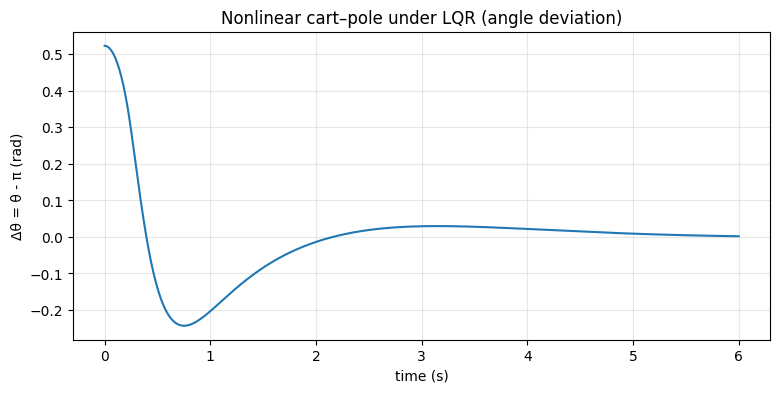

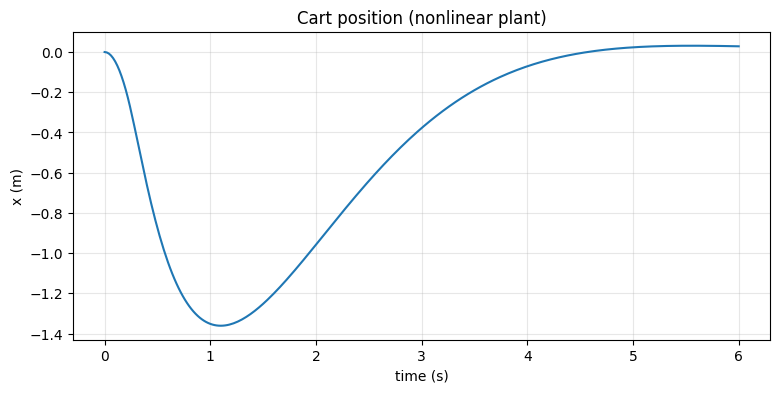

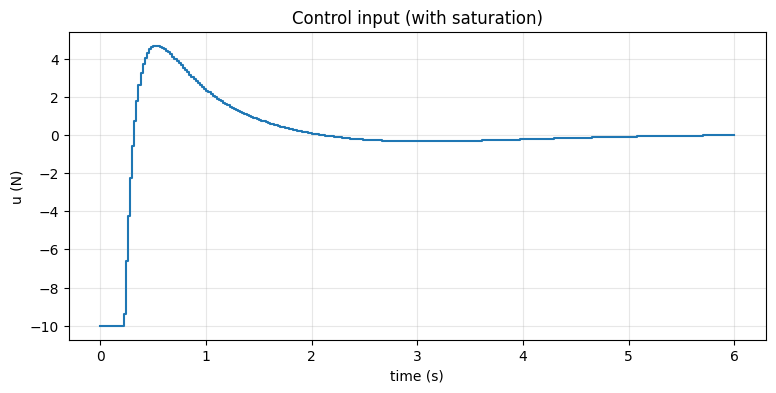

Final angle deviation (deg): 0.10317817538368841
Did it stabilize? (|Δθ| < 2° at end): True


In [4]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import solve_discrete_are


# -----------------------------
# Parameters
# -----------------------------
m_c = 1.0   # cart mass [kg]
m_p = 0.1   # pole mass [kg]
l   = 0.5   # pole length [m]
g   = 9.81  # gravity [m/s^2]

dt = 0.02   # discretization step for LQR and simulation [s]
T  = 6.0    # total simulation time [s]
N  = int(T / dt)

# LQR weights (tune as you like)
Q = np.diag([1.0, 50.0, 0.2, 1.0])  # penalize angle deviation strongly
R = np.array([[0.1]])               # control effort penalty

u_max = 10.0   # actuator saturation (set to None to disable)

# -----------------------------
# Nonlinear dynamics + integrator
# -----------------------------
def F_nonlinear(x, u, m_c=1.0, m_p=0.1, l=0.5, g=9.81):
    # x = [x, theta, xdot, thetadot]
    _, theta, x_dot, theta_dot = x
    u_val = u[0] if hasattr(u, '__len__') else u
    
    sin_th = np.sin(theta)
    cos_th = np.cos(theta)
    D = m_c + m_p * sin_th**2
    
    x_ddot = (u_val + m_p * sin_th * (l * theta_dot**2 + g * cos_th)) / D
    theta_ddot = (-(m_c + m_p) * g * sin_th - cos_th * (u_val + m_p * l * theta_dot**2 * sin_th)) / (l * D)
    
    return np.array([x_dot, theta_dot, x_ddot, theta_ddot])

def rk4_step(f, x, u, dt):
    k1 = f(x, u)
    k2 = f(x + 0.5*dt*k1, u)
    k3 = f(x + 0.5*dt*k2, u)
    k4 = f(x + dt*k3, u)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# -----------------------------
# Build controller K, then simulate NONLINEAR plant
# -----------------------------

# Continuous-time A and B matrices from 2.3
A_cont = np.array([
    [0, 0, 1, 0],
    [0, 0, 0, 1],
    [0, m_p * g / m_c, 0, 0],
    [0, (m_c + m_p) * g / (l * m_c), 0, 0]
])
B_cont = np.array([[0], [0], [1/m_c], [1/(l * m_c)]])

# Discretize using forward Euler: A_d = I + dt*A, B_d = dt*B
A_d = np.eye(4) + dt * A_cont
B_d = dt * B_cont

# Solve discrete-time algebraic Riccati equation
P = solve_discrete_are(A_d, B_d, Q, R)

# Compute LQR gain: K = (R + B'PB)^{-1} B'PA
K = np.linalg.solve(R + B_d.T @ P @ B_d, B_d.T @ P @ A_d)

print("LQR gain K:", K)

def simulate_nonlinear_from(x0, K, dt, N, u_max=None):
    """
    x0 is full state: [x, theta, xdot, thetadot].
    Control law: u = -K @ [Δx, Δθ, Δxdot, Δthetadot], where Δθ = theta - pi.
    """
    X = np.zeros((N+1, 4))
    U = np.zeros((N, 1))
    X[0] = x0
    for k in range(N):
        dx = np.array([
            X[k, 0],            # Δx (cart position about 0)
            X[k, 1] - np.pi,    # Δθ about upright
            X[k, 2],            # Δxdot
            X[k, 3],            # Δthetadot
        ])
        u = -K @ dx
        if u_max is not None:
            u = np.clip(u, -u_max, u_max)
        U[k, 0] = u
        X[k+1] = rk4_step(lambda x, uu: F_nonlinear(x, uu, m_c, m_p, l, g), X[k], u, dt)
    return X, U

x0 = np.array([0.0, np.pi + np.deg2rad(30.0), 0.0, 0.0])

X, U = simulate_nonlinear_from(x0, K, dt, N, u_max=u_max)

# -----------------------------
# Plot
# -----------------------------
t  = np.linspace(0.0, T, N+1)
tk = np.linspace(0.0, T, N)

plt.figure(figsize=(9, 4))
plt.plot(t, X[:,1] - np.pi)
plt.xlabel("time (s)")
plt.ylabel("Δθ = θ - π (rad)")
plt.title("Nonlinear cart–pole under LQR (angle deviation)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(9, 4))
plt.plot(t, X[:,0])
plt.xlabel("time (s)")
plt.ylabel("x (m)")
plt.title("Cart position (nonlinear plant)")
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(9, 4))
plt.step(tk, U[:,0], where='post')
plt.xlabel("time (s)")
plt.ylabel("u (N)")
plt.title("Control input (with saturation)" if u_max is not None else "Control input")
plt.grid(True, alpha=0.3)
plt.show()

print("Final angle deviation (deg):", np.rad2deg(X[-1,1] - np.pi))
print("Did it stabilize? (|Δθ| < 2° at end):", abs(np.rad2deg(X[-1,1] - np.pi)) < 2.0)


## Problem 3 — Obstacle Avoidance with the CRISP Solver

Adapt Example 4.4 from the lecture notes to implement a trajectory optimization in Python using the CRISP solver. See the paper for details: [CRISP](https://computationalrobotics.seas.harvard.edu/CRISP/). Run the code locally, or copy `crisp.py` into your Google Colab folder.

CRISP need QP solver, for example I use PIQP here. Install the solver using `pip install 'qpsolvers[piqp]'`. You may change to other solvers by looking into CRISP's source code.

We consider a unicycle robot that must travel from a start pose **A** to a goal pose **B** while avoiding circular (disk) obstacles.

#### System Model
We use standard unicycle (Dubins-like) kinematics in continuous time:
$$
\dot{x}(t)
= \begin{bmatrix}\dot p_x\\ \dot p_y\\ \dot \theta\end{bmatrix}
= \begin{bmatrix} v(t)\cos\theta(t)\\ v(t)\sin\theta(t)\\ \omega(t) \end{bmatrix},\quad
x=\begin{bmatrix}p_x& p_y& \theta\end{bmatrix}^\top,\;
u=\begin{bmatrix}v&\omega\end{bmatrix}^\top.
$$

Discretize on a uniform grid $t_k=kh$ for $k=0,\ldots,N$ with step $h>0$ using forward Euler:
$$
x_{k+1} = f_h(x_k,u_k)
:= \begin{bmatrix}
p_{x,k} + h\, v_k \cos\theta_k\\
p_{y,k} + h\, v_k \sin\theta_k\\
\theta_k + h\, \omega_k
\end{bmatrix}.
$$

#### Decision Variables
Optimize over $\{x_k\}_{k=0}^{N}$ and $\{u_k\}_{k=0}^{N-1}$, collected as
$$
z=\big[ x_0^\top,\; u_0^\top,\; x_1^\top,\; u_1^\top,\; \ldots,\; x_{N-1}^\top,\; u_{N-1}^\top,\; x_N^\top \big]^\top
\in \mathbb{R}^{(3+2)N+3}.
$$

#### Constraints

**(i) Initial condition.**
$$
x_0 = A \in \mathbb{R}^3.
$$

**(ii) Dynamics (equalities), for $k=0,\ldots,N-1$.**
$$
x_{k+1} - f_h(x_k,u_k) = 0.
$$

**(iii) Obstacle avoidance (inequalities).**  
Let $\mathcal{O}=\{(c_j,r_j)\}_{j=1}^{n_{\text{obs}}}$ with centers $c_j=\begin{bmatrix}c_{x,j}&c_{y,j}\end{bmatrix}^\top$ and radii $r_j>0$. Enforce a safety margin $\delta\ge 0$ at each knot:
$$
(p_{x,k}-c_{x,j})^2 + (p_{y,k}-c_{y,j})^2 \;\ge\; (r_j+\delta)^2,
\qquad \forall k=0,\ldots,N,\ \forall j.
$$

**(iv) Box limits (controls, optionally states).**
$$
v_{\min}\le v_k \le v_{\max},\qquad
\omega_{\min}\le \omega_k \le \omega_{\max},\qquad
k=0,\ldots,N-1.
$$


### 3.1 Write down your optimization problem 

According to the dynamics and the constraints, design the loss function yourself and write down the problem formulation as a mathematical optimization problem.

**Answer:**

We design an objective that (1) drives the robot to the goal, (2) penalizes control effort, and (3) encourages smooth trajectories. Let $B = [p_x^g, p_y^g, \theta^g]^\top$ be the goal pose.

$$\boxed{
\begin{aligned}
\min_{x_0,\ldots,x_N, u_0,\ldots,u_{N-1}} \quad & w_{\text{pos}}\left[(p_{x,N} - p_x^g)^2 + (p_{y,N} - p_y^g)^2\right] + w_\theta(\theta_N - \theta^g)^2 \\
& + w_u \sum_{k=0}^{N-1} \|u_k\|^2 + w_{\Delta u} \sum_{k=0}^{N-2} \|u_{k+1} - u_k\|^2 \\[1em]
\text{s.t.} \quad & x_0 = A \quad \text{(initial condition)} \\[0.5em]
& x_{k+1} = f_h(x_k, u_k), \quad k = 0,\ldots,N-1 \quad \text{(dynamics)} \\[0.5em]
& (p_{x,k} - c_{x,j})^2 + (p_{y,k} - c_{y,j})^2 \geq (r_j + \delta)^2, \quad \forall k, \forall j \quad \text{(obstacle avoidance)} \\[0.5em]
& v_{\min} \leq v_k \leq v_{\max}, \quad k = 0,\ldots,N-1 \quad \text{(velocity bounds)} \\[0.5em]
& \omega_{\min} \leq \omega_k \leq \omega_{\max}, \quad k = 0,\ldots,N-1 \quad \text{(angular rate bounds)}
\end{aligned}
}$$

where the discrete dynamics are:
$$f_h(x_k, u_k) = \begin{bmatrix} p_{x,k} + h\, v_k \cos\theta_k \\ p_{y,k} + h\, v_k \sin\theta_k \\ \theta_k + h\, \omega_k \end{bmatrix}$$

**Interpretation of objective terms:**
- **Terminal position cost**: Drives the robot to the goal location $(p_x^g, p_y^g)$
- **Terminal heading cost**: Aligns final orientation with goal heading $\theta^g$
- **Control effort**: Penalizes large velocities/turning rates for energy efficiency
- **Control smoothness**: Penalizes jerky motions by penalizing changes in control

### 3.2 Program your problem and solve it using CRISP

Crisp's interface allow you to solve the problem 

$$
\begin{align}
& \min_x f(x) \\
s.t. & \quad h(x) = 0\\
& \quad g(x) \geq 0\\
\end{align}
$$

When given the cost function $f$, its gradient and hessian $\nabla f, \nabla^2 f$, the equality and inequality constraint $h(x), g(x)$, and the jacobian of the constraint $\frac{\partial h}{\partial x}$ and $\frac{\partial g}{\partial x}$.

The code below provides a simple example:


In [1]:
from crisp import SQPSolver
import numpy as np

def cost(x):
    return x.dot(x)

def grad_cost(x):
    return 2*x

def hess_cost(x):
    return 2*np.eye(x.size)

def eq_cons(x):
    return np.array([ x[0] + x[1] - 1 , 
                        x[2] - x[3] + 1])

def jac_eq(x):
    return np.vstack([
        np.array([1,1,0,0,0]),
        np.array([0,0,1,-1,0])
    ])

def ineq_cons(x):
    
    return np.array([ x[2], x[3] ])

def jac_in(x):
    return np.vstack([
        np.array([0,0,1,0,0]),
        np.array([0,0,0,1,0])
    ])


x0 = np.zeros(5)

solver = SQPSolver(cost, grad_cost, hess_cost,
                    eq_cons, jac_eq,
                    ineq_cons, jac_in,
                    x0,
                    mu_eq_init=np.ones(2),
                    mu_in_init=np.ones(2),
                    max_iter=100)
x_opt, history = solver.solve()
print("Optimal x:", x_opt)

TR    predicted = 0.750000 , actual = 0.750000 , cost = 0.000000 , merit = 2.000000 , eq_vio = 1.000000 , in_vio = 0.000000 , QP_time = 0.000840s
REJ   predicted = 0.000000 , actual = 0.000000 , cost = 0.749971 , merit = 1.250000 , eq_vio = 0.499978 , in_vio = 0.000022 , QP_time = 0.000319s
Increase lower than tolerance at iter 1
TR+   predicted = 2.187760 , actual = 2.187760 , cost = 0.749971 , merit = 5.750260 , eq_vio = 0.499978 , in_vio = 0.000022 , QP_time = 0.000344s
TR    predicted = 2.062500 , actual = 2.062500 , cost = 1.062500 , merit = 3.562500 , eq_vio = 0.249949 , in_vio = 0.000051 , QP_time = 0.000328s
REJ   predicted = 0.000000 , actual = 0.000000 , cost = 1.500000 , merit = 1.500000 , eq_vio = 0.000000 , in_vio = 0.000000 , QP_time = 0.000260s
Solved at iter 4
Optimal x: [ 5.00000000e-01  5.00000000e-01  1.49686849e-10  1.00000000e+00
 -1.67234840e-24]


Then your task is to implement the obstacle avoidance problem using CRISP. The code structure is given, but you need to fill in objective, constraints and its derivative.

**TODO:** Finish `TODO` functions.

TR+   predicted = 209.479167 , actual = 209.479167 , cost = 1220.000000 , merit = 1220.000000 , eq_vio = 0.000000 , in_vio = 0.000000 , QP_time = 0.001983s
TR+   predicted = 356.043274 , actual = 357.749725 , cost = 1010.020833 , merit = 1010.520833 , eq_vio = 0.053831 , in_vio = 0.000000 , QP_time = 0.002407s
TR+   predicted = 446.189809 , actual = 475.811657 , cost = 650.248311 , merit = 652.771108 , eq_vio = 1.376244 , in_vio = 0.852500 , QP_time = 0.002197s
TR+   predicted = 157.563776 , actual = 163.817354 , cost = 170.749444 , merit = 176.959451 , eq_vio = 3.535106 , in_vio = 1.322500 , QP_time = 0.002506s
TR    predicted = 5.210720 , actual = 5.173338 , cost = 5.832165 , merit = 13.142097 , eq_vio = 4.311064 , in_vio = 0.000000 , QP_time = 0.002430s
TR    predicted = 0.055571 , actual = 0.040526 , cost = 1.068005 , merit = 7.968760 , eq_vio = 4.216504 , in_vio = 0.000000 , QP_time = 0.002248s
TR    predicted = 0.012927 , actual = 0.011919 , cost = 1.142164 , merit = 7.928234 , e

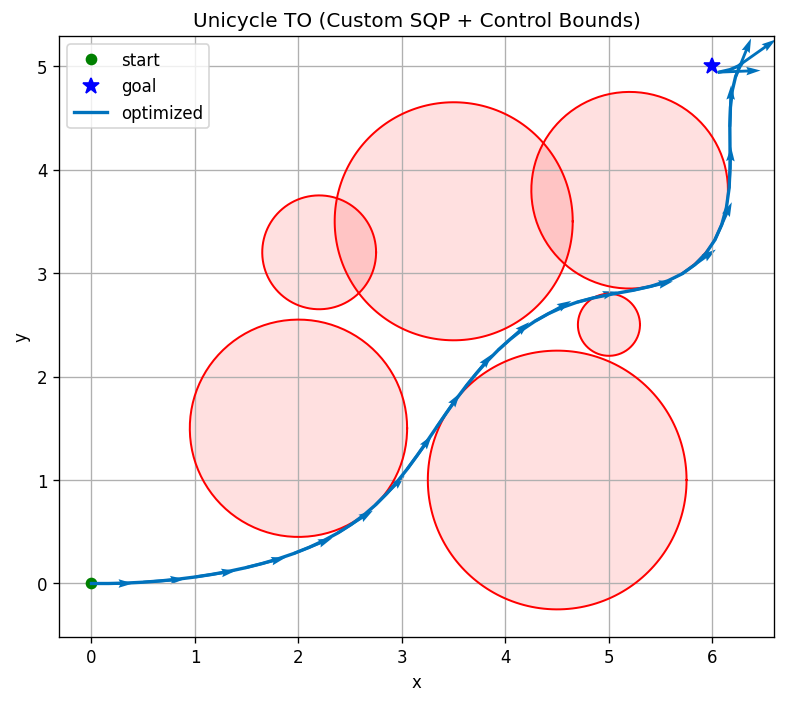

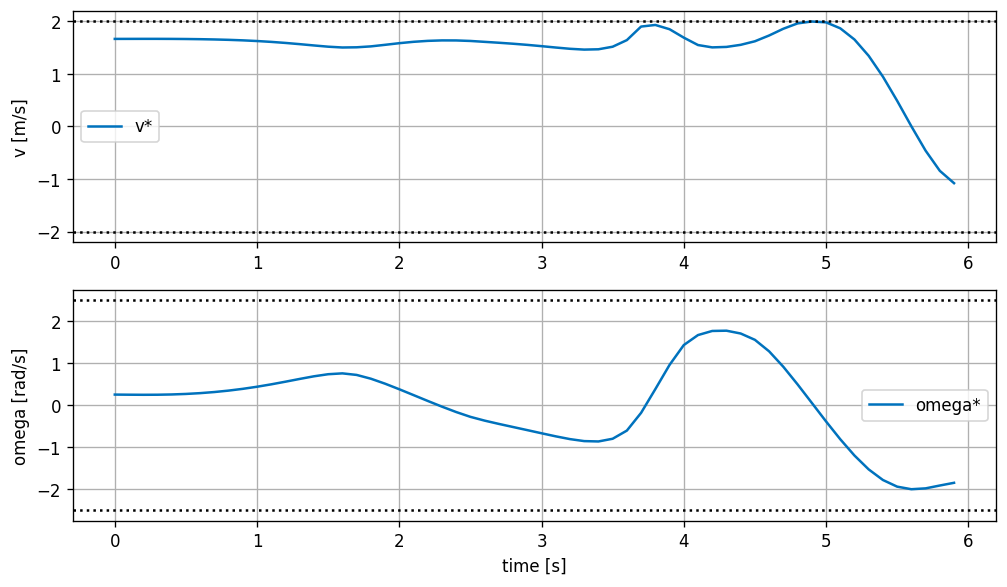

In [2]:
from __future__ import annotations

import math
from dataclasses import dataclass
from typing import Tuple

import numpy as np
from scipy import sparse as sp
import matplotlib.pyplot as plt

from crisp import SQPSolver  


# -------------------- Problem parameters --------------------
@dataclass
class Params:
    N: int = 60
    h: float = 0.1
    A: np.ndarray = np.array([0.0, 0.0, 0.0])
    B: np.ndarray = np.array([6.0, 5.0, 0.0])
    obstacles: np.ndarray = np.array([
        [2.0, 1.5, 0.8],
        [3.5, 3.5, 0.9],
        [5.2, 3.8, 0.7],
        [2.2, 3.2, 0.3],
        [4.5, 1.0, 1.0],
        [5.0, 2.5, 0.05],
    ])
    safety_margin: float = 0.25

    v_min: float = -2.0
    v_max: float = 2.0
    w_min: float = -2.5
    w_max: float = 2.5

    w_goal_pos: float = 20.0
    w_goal_theta: float = 20.0
    w_u: float = 0.05
    w_du: float = 0.2

    n_x: int = 3
    n_u: int = 2

    def __post_init__(self):
        self.Z_DIM = (self.n_x + self.n_u) * self.N + self.n_x


# -------------------- Index helpers --------------------
def idx_x(k: int, p: Params) -> slice:
    base = (p.n_x + p.n_u) * k
    return slice(base, base + p.n_x)


def idx_u(k: int, p: Params) -> slice:
    base = (p.n_x + p.n_u) * k + p.n_x
    return slice(base, base + p.n_u)


# -------------------- Pack / Unpack --------------------
def pack(X: np.ndarray, U: np.ndarray, p: Params) -> np.ndarray:
    z = np.zeros(p.Z_DIM, dtype=float)
    for kk in range(p.N):
        z[idx_x(kk, p)] = X[kk, :]
        z[idx_u(kk, p)] = U[kk, :]
    z[idx_x(p.N, p)] = X[p.N, :]
    return z


def unpack(z: np.ndarray, p: Params) -> Tuple[np.ndarray, np.ndarray]:
    X = np.zeros((p.N + 1, p.n_x), dtype=float)
    U = np.zeros((p.N, p.n_u), dtype=float)
    for kk in range(p.N):
        X[kk, :] = z[idx_x(kk, p)]
        U[kk, :] = z[idx_u(kk, p)]
    X[p.N, :] = z[idx_x(p.N, p)]
    return X, U


# -------------------- Dynamics --------------------
def f_disc(xk: np.ndarray, uk: np.ndarray, h: float) -> np.ndarray:
    px, py, th = xk
    v, w = uk
    return np.array([
        px + h * v * math.cos(th),
        py + h * v * math.sin(th),
        th + h * w,
    ])

# -------------------- Objective & derivatives --------------------
def objective(z: np.ndarray, p: Params) -> float:
    X, U = unpack(z, p)
    
    # Terminal cost: reach goal B
    dx = X[p.N, 0] - p.B[0]
    dy = X[p.N, 1] - p.B[1]
    dth = X[p.N, 2] - p.B[2]
    cost = p.w_goal_pos * (dx**2 + dy**2) + p.w_goal_theta * dth**2
    
    # Control effort
    for k in range(p.N):
        cost += p.w_u * (U[k, 0]**2 + U[k, 1]**2)
    
    # Control smoothness
    for k in range(p.N - 1):
        dv = U[k+1, 0] - U[k, 0]
        dw = U[k+1, 1] - U[k, 1]
        cost += p.w_du * (dv**2 + dw**2)
    
    return cost


def grad_cost(z: np.ndarray, p: Params) -> np.ndarray:
    X, U = unpack(z, p)
    grad = np.zeros(p.Z_DIM)
    
    # Terminal cost gradient
    dx = X[p.N, 0] - p.B[0]
    dy = X[p.N, 1] - p.B[1]
    dth = X[p.N, 2] - p.B[2]
    idx_N = idx_x(p.N, p)
    grad[idx_N.start] = 2 * p.w_goal_pos * dx
    grad[idx_N.start + 1] = 2 * p.w_goal_pos * dy
    grad[idx_N.start + 2] = 2 * p.w_goal_theta * dth
    
    # Control effort gradient
    for k in range(p.N):
        idx = idx_u(k, p)
        grad[idx.start] += 2 * p.w_u * U[k, 0]
        grad[idx.start + 1] += 2 * p.w_u * U[k, 1]
    
    # Control smoothness gradient
    for k in range(p.N - 1):
        idx_k = idx_u(k, p)
        idx_k1 = idx_u(k + 1, p)
        dv = U[k+1, 0] - U[k, 0]
        dw = U[k+1, 1] - U[k, 1]
        grad[idx_k.start] += -2 * p.w_du * dv
        grad[idx_k.start + 1] += -2 * p.w_du * dw
        grad[idx_k1.start] += 2 * p.w_du * dv
        grad[idx_k1.start + 1] += 2 * p.w_du * dw
    
    return grad


def hess_cost(z: np.ndarray, p: Params):
    H = np.zeros((p.Z_DIM, p.Z_DIM))
    
    # Terminal cost Hessian
    idx_N = idx_x(p.N, p)
    H[idx_N.start, idx_N.start] = 2 * p.w_goal_pos
    H[idx_N.start + 1, idx_N.start + 1] = 2 * p.w_goal_pos
    H[idx_N.start + 2, idx_N.start + 2] = 2 * p.w_goal_theta
    
    # Control effort Hessian
    for k in range(p.N):
        idx = idx_u(k, p)
        H[idx.start, idx.start] += 2 * p.w_u
        H[idx.start + 1, idx.start + 1] += 2 * p.w_u
    
    # Control smoothness Hessian
    for k in range(p.N - 1):
        idx_k = idx_u(k, p)
        idx_k1 = idx_u(k + 1, p)
        # d^2/du_k^2
        H[idx_k.start, idx_k.start] += 2 * p.w_du
        H[idx_k.start + 1, idx_k.start + 1] += 2 * p.w_du
        # d^2/du_{k+1}^2
        H[idx_k1.start, idx_k1.start] += 2 * p.w_du
        H[idx_k1.start + 1, idx_k1.start + 1] += 2 * p.w_du
        # Cross terms
        H[idx_k.start, idx_k1.start] = -2 * p.w_du
        H[idx_k1.start, idx_k.start] = -2 * p.w_du
        H[idx_k.start + 1, idx_k1.start + 1] = -2 * p.w_du
        H[idx_k1.start + 1, idx_k.start + 1] = -2 * p.w_du
    
    return H


# -------------------- Constraints --------------------
def eq_cons(z: np.ndarray, p: Params) -> np.ndarray:
    """Initial condition (3) + dynamics (3*N) = 3 + 3*N constraints."""
    X, U = unpack(z, p)
    cons = []
    
    # Initial condition: x_0 = A
    cons.extend(X[0, :] - p.A)
    
    # Dynamics: x_{k+1} - f(x_k, u_k) = 0
    for k in range(p.N):
        x_next = f_disc(X[k, :], U[k, :], p.h)
        cons.extend(X[k+1, :] - x_next)
    
    return np.array(cons)


def jac_eq(z: np.ndarray, p: Params):
    """Jacobian of equality constraints."""
    X, U = unpack(z, p)
    n_eq = 3 + 3 * p.N
    J = np.zeros((n_eq, p.Z_DIM))
    
    # Initial condition: d(x_0 - A)/dz
    idx0 = idx_x(0, p)
    J[0, idx0.start] = 1
    J[1, idx0.start + 1] = 1
    J[2, idx0.start + 2] = 1
    
    # Dynamics constraints
    for k in range(p.N):
        row = 3 + 3 * k
        idx_xk = idx_x(k, p)
        idx_uk = idx_u(k, p)
        idx_xk1 = idx_x(k + 1, p)
        
        th = X[k, 2]
        v = U[k, 0]
        
        # d(x_{k+1} - f)/dx_{k+1} = I
        J[row, idx_xk1.start] = 1
        J[row + 1, idx_xk1.start + 1] = 1
        J[row + 2, idx_xk1.start + 2] = 1
        
        # d(x_{k+1} - f)/dx_k = -df/dx_k
        # df/d(px) = [1, 0, 0], df/d(py) = [0, 1, 0]
        # df/d(th) = [-h*v*sin(th), h*v*cos(th), 0]
        J[row, idx_xk.start] = -1
        J[row + 1, idx_xk.start + 1] = -1
        J[row, idx_xk.start + 2] = p.h * v * math.sin(th)
        J[row + 1, idx_xk.start + 2] = -p.h * v * math.cos(th)
        J[row + 2, idx_xk.start + 2] = -1
        
        # d(x_{k+1} - f)/du_k = -df/du_k
        # df/dv = [h*cos(th), h*sin(th), 0]
        # df/dw = [0, 0, h]
        J[row, idx_uk.start] = -p.h * math.cos(th)
        J[row + 1, idx_uk.start] = -p.h * math.sin(th)
        J[row + 2, idx_uk.start + 1] = -p.h
    
    return J


def ineq_cons(z: np.ndarray, p: Params) -> np.ndarray:
    """Obstacle clearance + control box constraints, all as g(z) >= 0."""
    X, U = unpack(z, p)
    cons = []
    
    # Obstacle avoidance: (px - cx)^2 + (py - cy)^2 - (r + delta)^2 >= 0
    for k in range(p.N + 1):
        px, py = X[k, 0], X[k, 1]
        for j in range(p.obstacles.shape[0]):
            cx, cy, r = p.obstacles[j]
            r_eff = r + p.safety_margin
            cons.append((px - cx)**2 + (py - cy)**2 - r_eff**2)
    
    # Control bounds: v_min <= v <= v_max, w_min <= w <= w_max
    for k in range(p.N):
        v, w = U[k, 0], U[k, 1]
        cons.append(v - p.v_min)      # v >= v_min
        cons.append(p.v_max - v)      # v <= v_max
        cons.append(w - p.w_min)      # w >= w_min
        cons.append(p.w_max - w)      # w <= w_max
    
    return np.array(cons)


def jac_in(z: np.ndarray, p: Params):
    """Sparse Jacobian of ineq_cons matching the order in ineq_cons."""
    X, U = unpack(z, p)
    n_obs = p.obstacles.shape[0]
    n_ineq = (p.N + 1) * n_obs + 4 * p.N
    J = np.zeros((n_ineq, p.Z_DIM))
    
    row = 0
    # Obstacle avoidance Jacobian
    for k in range(p.N + 1):
        px, py = X[k, 0], X[k, 1]
        idx_xk = idx_x(k, p)
        for j in range(n_obs):
            cx, cy, _ = p.obstacles[j]
            # d/d(px) = 2*(px - cx), d/d(py) = 2*(py - cy)
            J[row, idx_xk.start] = 2 * (px - cx)
            J[row, idx_xk.start + 1] = 2 * (py - cy)
            row += 1
    
    # Control bounds Jacobian
    for k in range(p.N):
        idx_uk = idx_u(k, p)
        # v - v_min >= 0
        J[row, idx_uk.start] = 1
        row += 1
        # v_max - v >= 0
        J[row, idx_uk.start] = -1
        row += 1
        # w - w_min >= 0
        J[row, idx_uk.start + 1] = 1
        row += 1
        # w_max - w >= 0
        J[row, idx_uk.start + 1] = -1
        row += 1
    
    return J



# -------------------- Plotting --------------------
def plot_results(p: Params, X: np.ndarray, U: np.ndarray) -> None:
    blue = (0.0, 0.4470, 0.7410)

    fig = plt.figure(figsize=(8, 6.5), dpi=120)
    ax = fig.add_subplot(111)
    ax.set_title("Unicycle TO (Custom SQP + Control Bounds)")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True)
    ax.set_aspect("equal", adjustable="box")

    ang = np.linspace(0, 2 * math.pi, 200)
    for j in range(p.obstacles.shape[0]):
        cx, cy, r = p.obstacles[j]
        r_eff = r + p.safety_margin
        ox = cx + r_eff * np.cos(ang)
        oy = cy + r_eff * np.sin(ang)
        ax.plot(ox, oy, "r-", linewidth=1.2)
        ax.fill(ox, oy, color=(1, 0, 0), alpha=0.12, edgecolor="none")

    ax.plot(p.A[0], p.A[1], "go", label="start")
    ax.plot(p.B[0], p.B[1], "b*", markersize=10, label="goal")

    ax.plot(X[:, 0], X[:, 1], color=blue, linewidth=2.0, label="optimized")

    skip = max(1, p.N // 20)
    for k in range(0, p.N + 1, skip):
        px, py, th = X[k]
        ax.quiver(px, py, 0.4 * math.cos(th), 0.4 * math.sin(th),
                  angles='xy', scale_units='xy', scale=1, color=blue, width=0.004)

    ax.legend(loc="best")

    t = np.arange(p.N) * p.h
    fig2 = plt.figure(figsize=(8.5, 5.0), dpi=120)

    ax1 = fig2.add_subplot(211)
    ax1.plot(t, U[:, 0], color=blue, label="v*")
    ax1.axhline(p.v_min, linestyle=":", color="k")
    ax1.axhline(p.v_max, linestyle=":", color="k")
    ax1.set_ylabel("v [m/s]")
    ax1.grid(True)
    ax1.legend()

    ax2 = fig2.add_subplot(212)
    ax2.plot(t, U[:, 1], color=blue, label="omega*")
    ax2.axhline(p.w_min, linestyle=":", color="k")
    ax2.axhline(p.w_max, linestyle=":", color="k")
    ax2.set_xlabel("time [s]")
    ax2.set_ylabel("omega [rad/s]")
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

p = Params()
X0, U0 = np.zeros((p.N + 1, p.n_x)), np.zeros((p.N, p.n_u))
z0 = pack(X0, U0, p)

cost_fn = lambda z: objective(z, p)
grad_fn = lambda z: grad_cost(z, p)
hess_fn = lambda z: hess_cost(z, p)
eq_fn   = lambda z: eq_cons(z, p)
jeq_fn  = lambda z: jac_eq(z, p)
in_fn   = lambda z: ineq_cons(z, p)
jin_fn  = lambda z: jac_in(z, p)

m_eq = 3 + 3 * p.N
m_in = (p.N + 1) * p.obstacles.shape[0] + 4 * p.N  # add 4 bounds per stage
mu_eq_init = 1.0 * np.ones(m_eq)
mu_in_init = 1.0 * np.ones(m_in)

solver = SQPSolver(cost_fn, grad_fn, hess_fn,
                    eq_fn, jeq_fn,
                    in_fn, jin_fn,
                    x0=z0,
                    mu_eq_init=mu_eq_init,
                    mu_in_init=mu_in_init,
                    delta_init=0.5,
                    delta_max=2.0,
                    tol=1e-6,
                    max_iter=2000)

z_star, hist = solver.solve()

X_star, U_star = unpack(z_star, p)
print("\nTerminal state [px py theta]^T = [" +
        f"{X_star[-1,0]:.3f} {X_star[-1,1]:.3f} {X_star[-1,2]:.3f}]")

plot_results(p, X_star, U_star)

## Problem 4: Model Predictive Control for Pendulum Swing-Up

A simple pendulum consists of a point mass $m$ attached to a massless rigid rod of length $\ell$ that pivots freely under gravity $g$. We measure the angle $\theta$ from the **upright** position ($\theta=0$), with angular velocity $\omega=\dot{\theta}$, so the state is $x=[\theta,\omega]^\top$ and the control input is a torque $\tau$ applied at the pivot. The classic **swing-up** problem starts near the downward equilibrium ($\theta\approx\pi,\ \omega\approx0$) and seeks a torque sequence that drives the pendulum to the upright ($\theta=0,\ \omega=0$) efficiently while respecting actuator limits.

<figure style="text-align:center;">
  <img src="https://raw.githubusercontent.com/ComputationalRobotics/2025-ES-AM-158-PSET/main/PSET4/invertedpendulum.png" width="360" alt="Pendulum schematic">
  <figcaption style="color:#6a737d; font-style:italic;">
    Figure 2. Pendulum.
  </figcaption>
</figure>

**State / input:** $x=\begin{bmatrix}\theta\\\omega\end{bmatrix}$, $u=\tau$ (torque)  

**Parameters:** mass $m$, length $\ell$, gravity $g$.

**Bounds:** $\tau(t)\in[\tau_{\min},\tau_{\max}]$.

**Dynamics**
$$
\dot\theta=\omega,\qquad
\dot\omega=-\frac{g}{\ell}\sin\theta+\frac{1}{m\ell^2}\,\tau .
$$

**Initial condition**
$$
x(0)=\begin{bmatrix}\pi\\0\end{bmatrix}\quad(\text{downward at rest}).
$$

**Objective**
$$
\min_{\tau(\cdot)} \int_0^{T}
\Big[
q_a\big(\sin^2\theta+(\cos\theta-1)^2\big)
+ q_\omega\,\omega^2
+ q_r \,\tau^2
\Big]\,dt
$$
subject to the dynamics, initial condition, and torque bounds.

Below is a simulation environment to test your controller.


In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

def simulate_pendulum(u_fun,
                      x0=(0.01, 0.0), T=10.0, dt=0.01,
                      m=1.0, l=1.0, g=9.81,
                      tau_limits=None,
                      save_gif=False, gif_path="pendulum.gif", fps=None):
    """
    Simulate θ (upright=0) with torque policy u_fun(t, x) -> scalar.
    Returns (t, X, U). If save_gif, writes an animated GIF.
    """
    N = int(T/dt); t = np.linspace(0, T, N+1)
    X = np.zeros((N+1, 2)); X[0] = np.array(x0, float)
    U = np.zeros(N)

    def f(x, tt):
        th, w = x
        u = float(u_fun(tt, x))
        if tau_limits is not None: u = float(np.clip(u, tau_limits[0], tau_limits[1]))
        return np.array([w, (g/l)*np.sin(th) + u/(m*l*l)])

    def rk4(x, tt, h):
        k1 = f(x, tt)
        k2 = f(x + 0.5*h*k1, tt + 0.5*h)
        k3 = f(x + 0.5*h*k2, tt + 0.5*h)
        k4 = f(x + h*k3,     tt + h)
        return x + (h/6.0)*(k1 + 2*k2 + 2*k3 + k4)

    for k in range(N):
        th, w = X[k]
        u = float(u_fun(t[k], X[k]))
        if tau_limits is not None: u = float(np.clip(u, tau_limits[0], tau_limits[1]))
        U[k] = u
        X[k+1] = rk4(X[k], t[k], dt)

    if save_gif:
        xx_full = l*np.sin(X[:,0])
        yy_full = l*np.cos(X[:,0])

        stride = 10
        idx = np.arange(0, N+1, stride)
        xx, yy = xx_full[idx], yy_full[idx]
        fig, ax = plt.subplots(figsize=(5,5))
        ax.set_aspect("equal", adjustable="box")
        ax.set_xlim(-1.15*l, 1.15*l); ax.set_ylim(-1.15*l, 1.15*l); ax.axis("off")
        ax.plot(0, 0, "o", ms=6, color="black")
        rod, = ax.plot([0, xx[0]], [0, yy[0]], lw=3, alpha=0.9)
        bob = plt.Circle((xx[0], yy[0]), 0.06*l, ec="black", lw=1.2, fc="#87CEFA")
        ax.add_patch(bob)
        def update(i):
            rod.set_data([0, xx[i]], [0, yy[i]])
            bob.center = (xx[i], yy[i])
            return rod, bob
        out_fps = max(1, int(1/(dt*stride))) if fps is None else fps
        ani = FuncAnimation(fig, update, frames=len(idx), interval=1000*dt*stride, blit=True)
        ani.save(gif_path, writer="pillow", fps=out_fps)
        plt.close(fig)

    return t, X, U


t, X, U = simulate_pendulum(lambda tt, x: 0.0, save_gif=True)



### 4.1 Trajectory optimization
With $N=50$ and $dt=0.1$, solve the trajectory optimization problem of swinging up the pendulum from the bottom right position: parameterize controls, discretize dynamics on each interval, and enforce control bound constraints. Plot your optimal trajectory and control signal.

This problem is similar to Problem 3.



Optimization terminated successfully    (Exit mode 0)
            Current function value: 232.82222815923427
            Iterations: 118
            Function evaluations: 18065
            Gradient evaluations: 118

Success: True | Status: 0
Message: Optimization terminated successfully
Final objective: 232.82222815923427


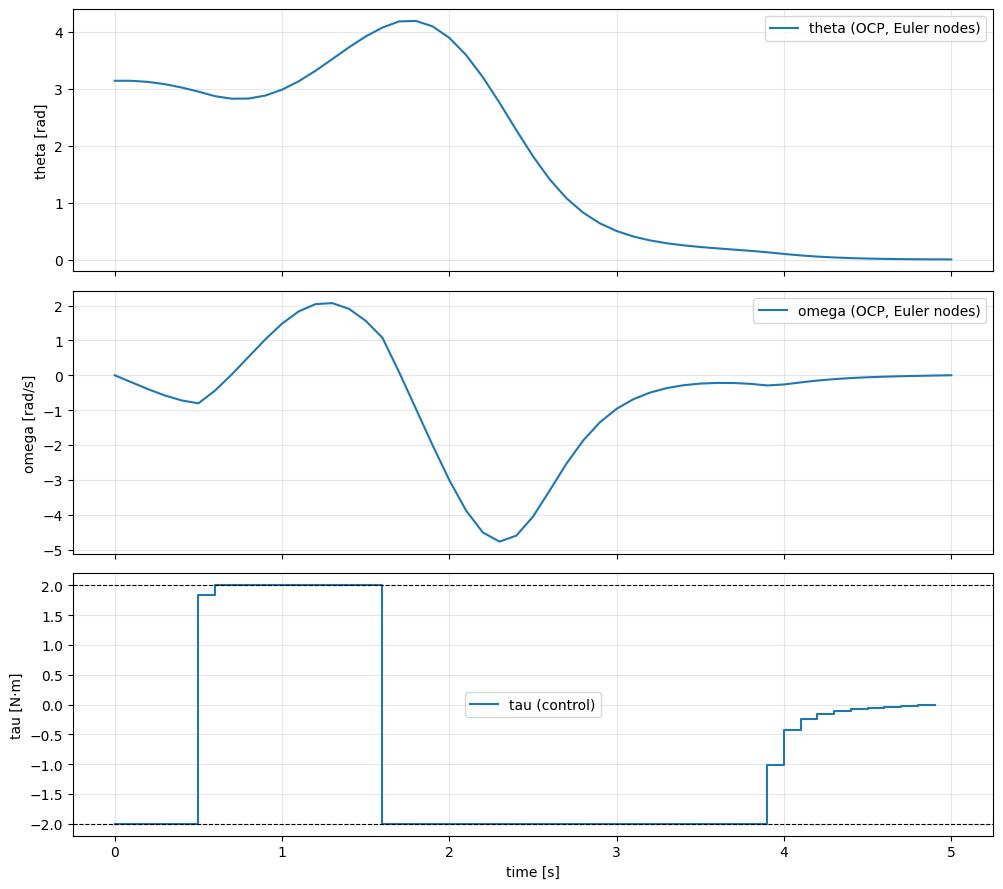

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Problem setup (pendulum)
# -----------------------------
N = 50
dt = 0.1
T = N * dt
m, l, g = 1.0, 1.0, 9.81
x0 = np.array([np.pi, 0.0])  # [theta (upright=0), omega]

# cost weights
q_a, q_omega, q_r = 20.0, 2.0, 1e-2
u_min, u_max = -2.0, 2.0

def f_pend(x, u):
    th, w = x
    return np.array([w, (g/l)*np.sin(th) + u/(m*l*l)], dtype=float)

# -----------------------------
# Decision variables: z = [th_0..th_N, w_0..w_N, u_0..u_{N-1}]
# -----------------------------
def unpack(z):
    th = z[0:N+1]
    w  = z[N+1:2*(N+1)]
    u  = z[2*(N+1):]
    return th, w, u

def pack(th, w, u):
    return np.concatenate([th, w, u], axis=0)

# -----------------------------
# Objective (pendulum swing-up)
# J ≈ ∑ dt * [ q_a( sin^2 th + (cos th - 1)^2 ) + q_omega w^2 + q_r u^2 ]  (+ terminal state term)
# -----------------------------
def objective(z):
    th, w, u = unpack(z)
    cost = 0.0
    # Running cost (trapezoidal-ish: use all state nodes, control at each interval)
    for k in range(N+1):
        # Angle cost: sin^2(th) + (cos(th) - 1)^2 = 2 - 2*cos(th) (simplifies to penalize deviation from upright)
        angle_cost = np.sin(th[k])**2 + (np.cos(th[k]) - 1)**2
        cost += dt * q_a * angle_cost
        cost += dt * q_omega * w[k]**2
    for k in range(N):
        cost += dt * q_r * u[k]**2
    return cost

# -----------------------------
# Multiple-shooting equality constraints (Euler)
# -----------------------------
def dynamics_constraints(z):
    th, w, u = unpack(z)
    cons = []
    # Initial conditions
    cons.append(th[0] - x0[0])  # th_0 = pi
    cons.append(w[0] - x0[1])   # w_0 = 0
    # Dynamics: x_{k+1} = x_k + dt * f(x_k, u_k)
    for k in range(N):
        xk = np.array([th[k], w[k]])
        xdot = f_pend(xk, u[k])
        # th_{k+1} = th_k + dt * w_k
        cons.append(th[k+1] - th[k] - dt * xdot[0])
        # w_{k+1} = w_k + dt * (g/l * sin(th_k) + u_k / (m*l^2))
        cons.append(w[k+1] - w[k] - dt * xdot[1])
    return np.array(cons)

# -----------------------------
# Bounds
# -----------------------------
from scipy.optimize import minimize, NonlinearConstraint

# Bounds: theta and omega are unbounded, u is bounded
bounds = []
for k in range(N+1):
    bounds.append((None, None))  # th_k unbounded
for k in range(N+1):
    bounds.append((None, None))  # w_k unbounded
for k in range(N):
    bounds.append((u_min, u_max))  # u_k bounded

# -----------------------------
# Initial guess: linear interpolation from pi to 0 with bang-bang control
# -----------------------------
th_init = np.linspace(np.pi, 0, N+1)  # linearly interpolate from downward to upright
w_init = np.zeros(N+1)
# Estimate velocity from position change
for k in range(N):
    w_init[k] = (th_init[k+1] - th_init[k]) / dt
w_init[N] = w_init[N-1]

# Initial control: bang-bang (push hard at start, brake at end)
u_init = np.zeros(N)
for k in range(N):
    if k < N // 2:
        u_init[k] = u_max  # accelerate
    else:
        u_init[k] = u_min  # decelerate

z0 = pack(th_init, w_init, u_init)

# -----------------------------
# Solve
# -----------------------------
eq_constraint = {'type': 'eq', 'fun': dynamics_constraints}

res = minimize(
    objective,
    z0,
    method='SLSQP',
    bounds=bounds,
    constraints=eq_constraint,
    options={'maxiter': 1000, 'ftol': 1e-9, 'disp': True}
)

print("\nSuccess:", res.success, "| Status:", res.status)
print("Message:", res.message)
print("Final objective:", res.fun)

# -----------------------------
# Extract & verify by RK4 sim with u_k (piecewise-constant)
# -----------------------------
th_sol, w_sol, u_sol = unpack(res.x)
t_nodes = np.linspace(0.0, T, N+1)
t_ctrl  = np.linspace(0.0, T - dt, N)


# -----------------------------
# Plots
# -----------------------------
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

axes[0].plot(t_nodes, th_sol, label="theta (OCP, Euler nodes)")
axes[0].set_ylabel("theta [rad]"); axes[0].legend(); axes[0].grid(alpha=0.3)

axes[1].plot(t_nodes, w_sol, label="omega (OCP, Euler nodes)")
axes[1].set_ylabel("omega [rad/s]"); axes[1].legend(); axes[1].grid(alpha=0.3)

axes[2].step(t_ctrl, u_sol, where='post', label="tau (control)")
axes[2].axhline(u_min, ls='--', c='k', lw=0.8); axes[2].axhline(u_max, ls='--', c='k', lw=0.8)
axes[2].set_xlabel("time [s]"); axes[2].set_ylabel("tau [N·m]"); axes[2].legend(); axes[2].grid(alpha=0.3)

plt.tight_layout(); plt.show()


### 4.2 Failure of open loop control

Now we solved out a trajectory with a given initial state. However, does this imply that if we simply run the planned controls on a real system, i.e., doing open-loop control, the trajectory will behave as planned? Unfortunately the answer is No, trajectory optimization only produces an approximate solution to the optimal control problem (OCP), regardless of what transcription method is used. So the error may cumulate along time horizon.

Rollout the control to see the fail of swing up. 

**TODO:** Finish the code and comment on what you see.

**Observation:** The open-loop rollout (red dashed) **completely fails** to swing up the pendulum:

- **Planned trajectory (blue)**: Successfully swings from θ=π → 0 (upright), ending at rest
- **Actual trajectory (red)**: Diverges early, oscillates around the downward position, and ends at θ≈2.5 rad — nowhere near upright!

The failure occurs because:

1. **Discretization mismatch**: The OCP used Euler integration (dt=0.1s), but the simulation uses RK4 (dt=0.01s). These integrators produce different trajectories even with identical controls.

2. **Error accumulation**: Small initial errors compound rapidly. By t≈2s, the trajectories have completely diverged — the actual pendulum doesn't have enough energy to reach upright, and instead oscillates around the bottom.

3. **No feedback**: The open-loop control blindly applies the pre-computed sequence regardless of the actual state. Once the system deviates from the planned path, the remaining controls are meaningless.

4. **Unstable dynamics**: Near the upright equilibrium, errors grow exponentially. Without feedback, the system cannot stabilize.

This motivates **Model Predictive Control (MPC)** in 4.3, where we re-solve the optimization at each timestep using the actual current state, providing feedback to correct for errors.

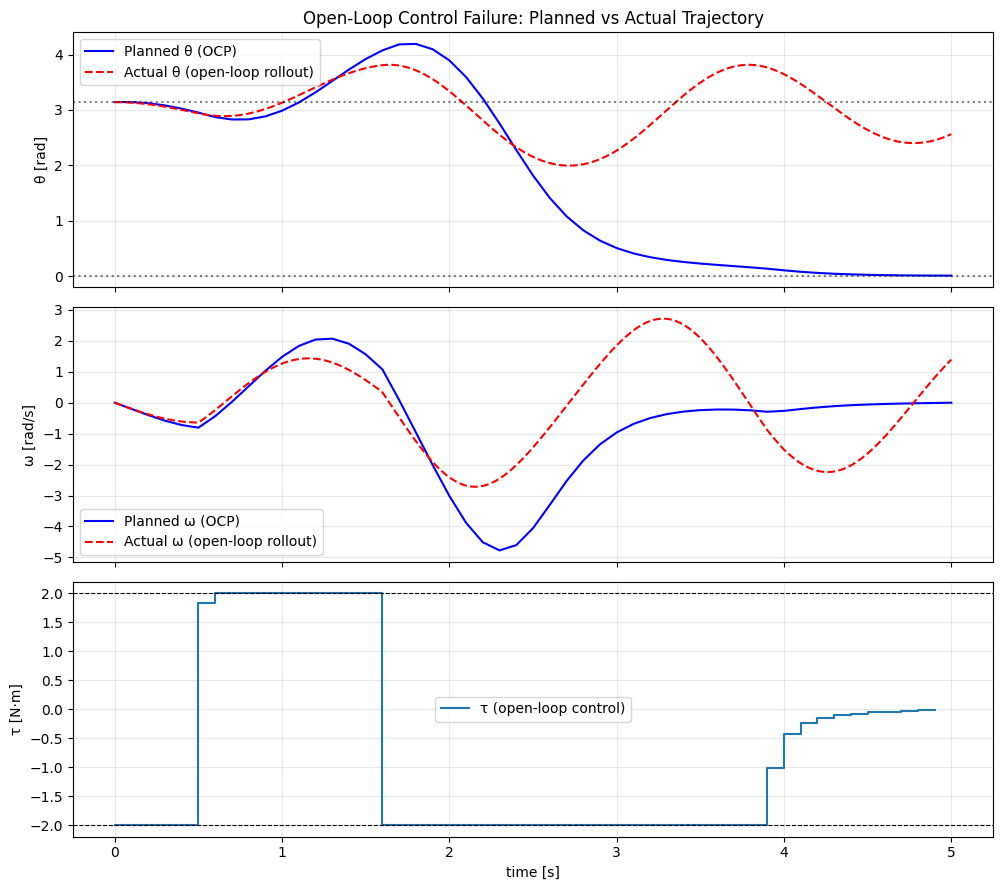

Planned final state:  θ = 0.0081 rad, ω = 0.0005 rad/s
Actual final state:   θ = 2.5627 rad, ω = 1.3948 rad/s
Final θ error: 2.5546 rad = 146.37°


In [8]:
def u_fun(t, x):
    k = int(t // dt)
    if k < 0: k = 0
    if k >= len(u_sol): k = len(u_sol) - 1
    return float(u_sol[k])  # open-loop (ignores x)

# --- “real-world” simulation (can be finer dt than planning; choose dt_sim) ---
dt_sim = 0.01  # finer integration for verification
t_sim, X_sim, U_sim = simulate_pendulum(
    u_fun,
    x0=x0, T=T,
    tau_limits=(u_min, u_max),
    save_gif=True  # set True to export an animation
)

# -----------------------------
# Plot: Compare planned vs actual (open-loop rollout)
# -----------------------------
fig, axes = plt.subplots(3, 1, figsize=(10, 9), sharex=True)

# Theta comparison
axes[0].plot(t_nodes, th_sol, 'b-', label="Planned θ (OCP)")
axes[0].plot(t_sim, X_sim[:, 0], 'r--', label="Actual θ (open-loop rollout)")
axes[0].axhline(0, ls=':', c='k', alpha=0.5)
axes[0].axhline(np.pi, ls=':', c='k', alpha=0.5)
axes[0].set_ylabel("θ [rad]")
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_title("Open-Loop Control Failure: Planned vs Actual Trajectory")

# Omega comparison
axes[1].plot(t_nodes, w_sol, 'b-', label="Planned ω (OCP)")
axes[1].plot(t_sim, X_sim[:, 1], 'r--', label="Actual ω (open-loop rollout)")
axes[1].set_ylabel("ω [rad/s]")
axes[1].legend()
axes[1].grid(alpha=0.3)

# Control
axes[2].step(t_ctrl, u_sol, where='post', label="τ (open-loop control)")
axes[2].axhline(u_min, ls='--', c='k', lw=0.8)
axes[2].axhline(u_max, ls='--', c='k', lw=0.8)
axes[2].set_xlabel("time [s]")
axes[2].set_ylabel("τ [N·m]")
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print final state comparison
print(f"Planned final state:  θ = {th_sol[-1]:.4f} rad, ω = {w_sol[-1]:.4f} rad/s")
print(f"Actual final state:   θ = {X_sim[-1, 0]:.4f} rad, ω = {X_sim[-1, 1]:.4f} rad/s")
print(f"Final θ error: {np.abs(X_sim[-1, 0] - th_sol[-1]):.4f} rad = {np.rad2deg(np.abs(X_sim[-1, 0] - th_sol[-1])):.2f}°")

### 4.3 Model Predictive Control

Now we will use model predictive control to get a feedback controller. 
Basically at every time step, we solve a trajectory optimization problem to obtain an open-loop state-control trajectory, but we only execute the first control input. 
Executing the first control input will bring the system to a new state, and we resolve the trajectory optimization problem with this new initial state.
When solving the new TO problem, you can reuse the solution from previous solve as the initial guess.

**TODO:** Finish the code and plot the final trajectory

Running MPC for pendulum swing-up...
Parameters: N=50, dt=0.1, u_bounds=[-2.0, 2.0]
  Step   0 (t=0.0s): θ=3.152, ω=0.197, u=2.00
  Step   1 (t=0.1s): θ=3.180, ω=0.374, u=2.00
  Step   2 (t=0.2s): θ=3.225, ω=0.516, u=2.00
  Step   3 (t=0.3s): θ=3.282, ω=0.607, u=2.00
  Step   4 (t=0.4s): θ=3.345, ω=0.640, u=2.00
  Step  20 (t=2.0s): θ=2.585, ω=2.021, u=2.00
  Warning step 34: Positive directional derivative for linesearch
  Warning step 36: Positive directional derivative for linesearch
  Step  40 (t=4.0s): θ=1.644, ω=1.614, u=2.00
  Warning step 49: Positive directional derivative for linesearch
  Step  60 (t=6.0s): θ=2.374, ω=-5.538, u=-0.75
  Step  80 (t=8.0s): θ=-1.857, ω=-4.861, u=1.64
  Step 100 (t=10.0s): θ=-6.694, ω=-1.367, u=0.03
  Step 120 (t=12.0s): θ=-12.507, ω=-0.243, u=0.36
  Step 140 (t=14.0s): θ=-12.566, ω=-0.000, u=0.00

Final state: θ=-12.5664 rad (-0.0°), ω=0.0000 rad/s
Final energy: E=9.8100 J (target: 9.8100 J)
✓ MPC successfully swung up the pendulum with limited 

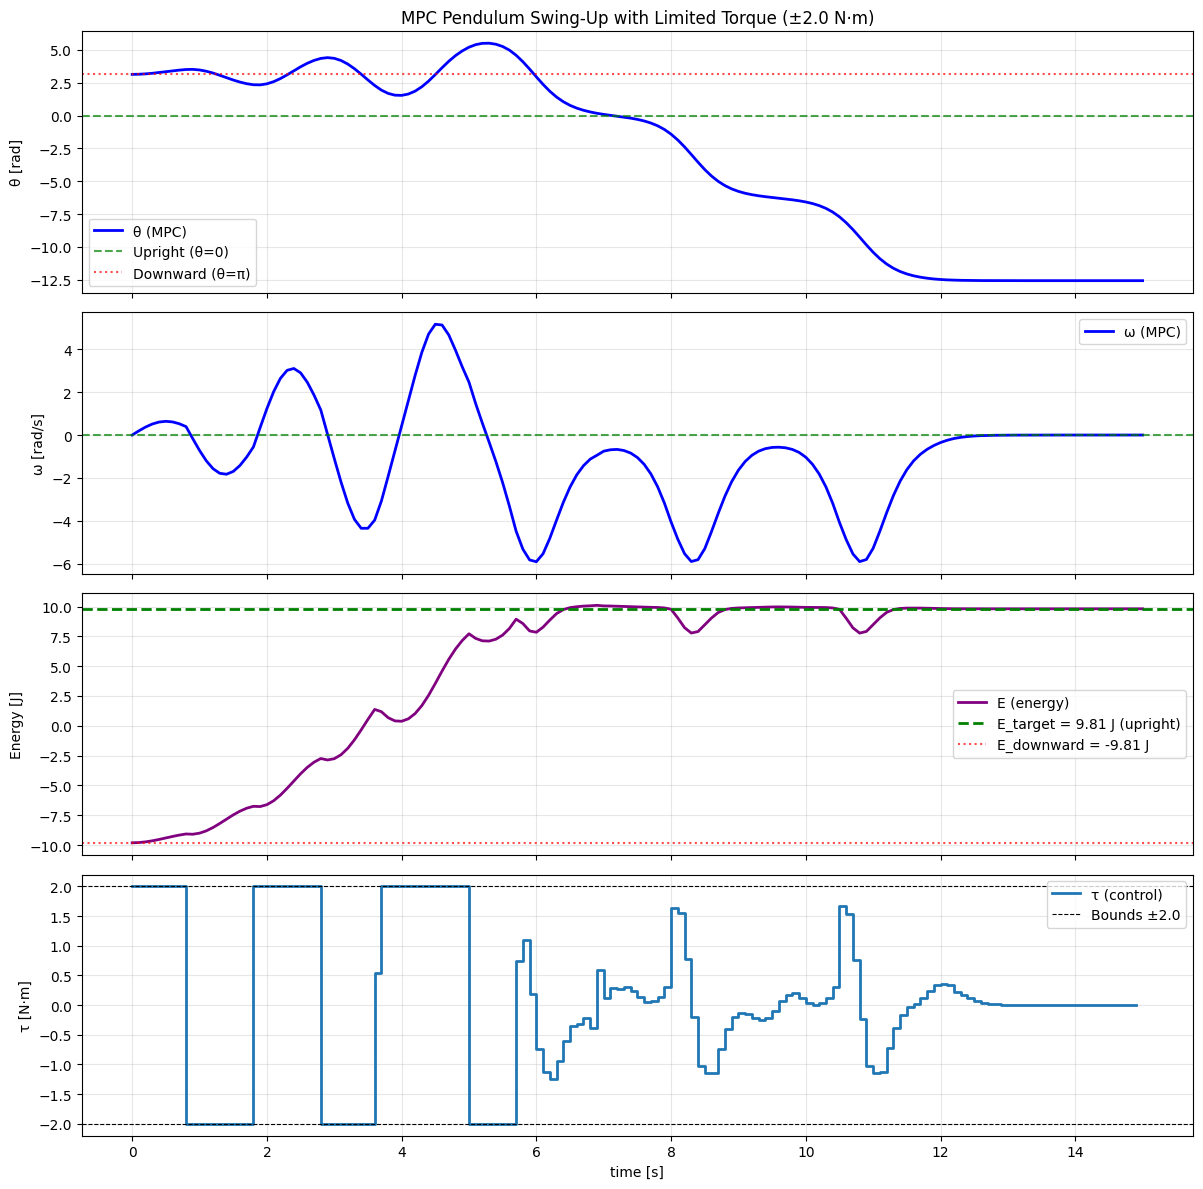


Generating animation...
Animation saved to pendulum_mpc.gif


In [ ]:
##############################
# MPC for Pendulum Swing-Up (reusing 4.1 structure)
# With SAME control limits as 4.1: ±2 N·m
# Uses ENERGY SHAPING to enable swing-up with limited torque
##############################

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# -----------------------------
# Parameters (SAME as 4.1)
# -----------------------------
N_mpc = 50        # MPC horizon
dt_mpc = 0.1      # planning timestep  
dt_sim = 0.01     # simulation timestep (finer for RK4)
T_total = 15.0    # increased simulation time (swing-up takes longer with limited torque)

m, l, g = 1.0, 1.0, 9.81

# Target energy at upright: E = 0.5*m*l²*ω² + m*g*l*cos(θ)
# At θ=0, ω=0: E_target = m*g*l
E_target = m * g * l  # ≈ 9.81 J

# Cost weights - tuned for energy-based swing-up
q_a = 5.0          # angle cost (reduced - we focus on energy first)
q_omega = 0.1      # velocity penalty (very low to allow fast swinging)
q_r = 1e-3         # control effort
q_energy = 2.0     # ENERGY SHAPING: penalize deviation from target energy

# Terminal cost weights - must be VERY strong to catch and stabilize
q_terminal_angle = 2000.0   # strongly pull toward upright at horizon end
q_terminal_omega = 1000.0   # CRITICAL: must stop at upright, not pass through

# Control bounds - SAME AS 4.1
u_min_mpc, u_max_mpc = -2.0, 2.0

# Initial state (downward at rest)
x0_mpc = np.array([np.pi, 0.0])

# -----------------------------
# Energy function
# -----------------------------
def energy(th, w):
    """Total mechanical energy: E = 0.5*m*l²*ω² + m*g*l*cos(θ)"""
    return 0.5 * m * l**2 * w**2 + m * g * l * np.cos(th)

# -----------------------------
# Dynamics (same as 4.1)
# -----------------------------
def f_pend_mpc(x, u):
    th, w = x
    return np.array([w, (g/l)*np.sin(th) + u/(m*l*l)], dtype=float)

def rk4_step_mpc(x, u, dt):
    k1 = f_pend_mpc(x, u)
    k2 = f_pend_mpc(x + 0.5*dt*k1, u)
    k3 = f_pend_mpc(x + 0.5*dt*k2, u)
    k4 = f_pend_mpc(x + dt*k3, u)
    return x + (dt/6.0)*(k1 + 2*k2 + 2*k3 + k4)

# -----------------------------
# Pack/Unpack (same structure as 4.1)
# z = [th_0..th_N, w_0..w_N, u_0..u_{N-1}]
# -----------------------------
def unpack_mpc(z, N):
    th = z[0:N+1]
    w  = z[N+1:2*(N+1)]
    u  = z[2*(N+1):]
    return th, w, u

def pack_mpc(th, w, u):
    return np.concatenate([th, w, u], axis=0)

# -----------------------------
# Objective with ENERGY SHAPING + CATCH TERM
# -----------------------------
def mpc_objective(z, N, x_current):
    th, w, u = unpack_mpc(z, N)
    cost = 0.0
    
    # Running cost with energy shaping
    for k in range(N+1):
        # Angle cost: penalize deviation from upright
        angle_cost = np.sin(th[k])**2 + (np.cos(th[k]) - 1)**2
        cost += dt_mpc * q_a * angle_cost
        cost += dt_mpc * q_omega * w[k]**2
        
        # ENERGY SHAPING: penalize deviation from target energy
        E_k = energy(th[k], w[k])
        cost += dt_mpc * q_energy * (E_k - E_target)**2
        
        # CATCH TERM: heavily penalize velocity when NEAR upright
        # cos(θ) > 0.5 means |θ| < 60° from upright
        # This tells MPC to "slow down when approaching the goal"
        if k > 0:  # don't apply at initial state (can't change it)
            nearness_to_upright = max(0, np.cos(th[k]))  # 1 at upright, 0 at horizontal, negative below
            catch_weight = 50.0 * nearness_to_upright**2  # stronger as we get closer
            cost += dt_mpc * catch_weight * w[k]**2
    
    for k in range(N):
        cost += dt_mpc * q_r * u[k]**2
    
    # Terminal cost - VERY strong to catch and hold
    terminal_angle_cost = np.sin(th[N])**2 + (np.cos(th[N]) - 1)**2
    cost += q_terminal_angle * terminal_angle_cost
    cost += q_terminal_omega * w[N]**2
    
    # Penalize terminal energy deviation
    E_terminal = energy(th[N], w[N])
    cost += 100.0 * (E_terminal - E_target)**2
    
    return cost

# -----------------------------
# Dynamics constraints (parametric in current state)
# -----------------------------
def mpc_dynamics_constraints(z, N, x_current):
    th, w, u = unpack_mpc(z, N)
    cons = []
    
    # Initial condition: x_0 = x_current
    cons.append(th[0] - x_current[0])
    cons.append(w[0] - x_current[1])
    
    # Dynamics (Euler discretization)
    for k in range(N):
        xk = np.array([th[k], w[k]])
        xdot = f_pend_mpc(xk, u[k])
        cons.append(th[k+1] - th[k] - dt_mpc * xdot[0])
        cons.append(w[k+1] - w[k] - dt_mpc * xdot[1])
    
    return np.array(cons)

# -----------------------------
# Solve one MPC step
# -----------------------------
def solve_mpc(x_current, z_init, N):
    bounds = []
    for _ in range(N+1): bounds.append((None, None))  # th unbounded
    for _ in range(N+1): bounds.append((None, None))  # w unbounded
    for _ in range(N): bounds.append((u_min_mpc, u_max_mpc))  # u bounded
    
    eq_constraint = {
        'type': 'eq',
        'fun': lambda z: mpc_dynamics_constraints(z, N, x_current)
    }
    
    res = minimize(
        lambda z: mpc_objective(z, N, x_current),
        z_init,
        method='SLSQP',
        bounds=bounds,
        constraints=eq_constraint,
        options={'maxiter': 500, 'ftol': 1e-8, 'disp': False}
    )
    return res

# -----------------------------
# Warm-start by shifting solution
# -----------------------------
def warmstart_shift(z_prev, N):
    th_prev, w_prev, u_prev = unpack_mpc(z_prev, N)
    
    th_new = np.zeros(N+1)
    w_new = np.zeros(N+1)
    th_new[:-1] = th_prev[1:]
    th_new[-1] = th_prev[-1]
    w_new[:-1] = w_prev[1:]
    w_new[-1] = w_prev[-1]
    
    u_new = np.zeros(N)
    u_new[:-1] = u_prev[1:]
    u_new[-1] = u_prev[-1]
    
    return pack_mpc(th_new, w_new, u_new)

# -----------------------------
# Initial guess - designed for energy pumping
# -----------------------------
def create_init_guess(x_current, N):
    # Start from current state
    th_init = np.zeros(N+1)
    w_init = np.zeros(N+1)
    th_init[0] = x_current[0]
    w_init[0] = x_current[1]
    
    # Oscillating control for energy pumping
    # Apply torque in direction of motion to pump energy
    u_init = np.zeros(N)
    for k in range(N):
        # Alternate torque to pump energy (like pushing a swing)
        phase = (k * dt_mpc) * 2 * np.pi / 2.0  # ~2 second period
        u_init[k] = u_max_mpc * np.sin(phase)
    
    # Roll out dynamics with this control to get feasible trajectory guess
    for k in range(N):
        xdot = f_pend_mpc(np.array([th_init[k], w_init[k]]), u_init[k])
        th_init[k+1] = th_init[k] + dt_mpc * xdot[0]
        w_init[k+1] = w_init[k] + dt_mpc * xdot[1]
    
    return pack_mpc(th_init, w_init, u_init)

# -----------------------------
# MPC Loop
# -----------------------------
print("Running MPC for pendulum swing-up...")
print(f"Parameters: N={N_mpc}, dt={dt_mpc}, u_bounds=[{u_min_mpc}, {u_max_mpc}]")

n_steps = int(T_total / dt_mpc)
mpc_states = [x0_mpc.copy()]
mpc_controls = []
mpc_times = [0.0]

x_current = x0_mpc.copy()
z_current = create_init_guess(x_current, N_mpc)

for step in range(n_steps):
    t_now = step * dt_mpc
    
    # Solve MPC
    res = solve_mpc(x_current, z_current, N_mpc)
    
    if not res.success:
        print(f"  Warning step {step}: {res.message}")
    
    th_sol, w_sol, u_sol = unpack_mpc(res.x, N_mpc)
    
    # Apply first control
    u_apply = np.clip(u_sol[0], u_min_mpc, u_max_mpc)
    mpc_controls.append(u_apply)
    
    # Simulate true system (RK4)
    n_sim = int(dt_mpc / dt_sim)
    x_next = x_current.copy()
    for _ in range(n_sim):
        x_next = rk4_step_mpc(x_next, u_apply, dt_sim)
    
    x_current = x_next
    mpc_states.append(x_current.copy())
    mpc_times.append(t_now + dt_mpc)
    
    # Warm-start next iteration
    z_current = warmstart_shift(res.x, N_mpc)
    th_w, w_w, u_w = unpack_mpc(z_current, N_mpc)
    th_w[0] = x_current[0]
    w_w[0] = x_current[1]
    z_current = pack_mpc(th_w, w_w, u_w)
    
    if step % 20 == 0 or step < 5:
        print(f"  Step {step:3d} (t={t_now:.1f}s): θ={x_current[0]:.3f}, ω={x_current[1]:.3f}, u={u_apply:.2f}")

# Convert to arrays
mpc_states = np.array(mpc_states)
mpc_controls = np.array(mpc_controls)
mpc_times = np.array(mpc_times)

# Check success
final_th = mpc_states[-1, 0]
final_w = mpc_states[-1, 1]
final_th_norm = np.arctan2(np.sin(final_th), np.cos(final_th))
final_E = energy(final_th, final_w)

print(f"\nFinal state: θ={final_th:.4f} rad ({np.rad2deg(final_th_norm):.1f}°), ω={final_w:.4f} rad/s")
print(f"Final energy: E={final_E:.4f} J (target: {E_target:.4f} J)")

# Success criteria: within ~17° of upright with small velocity
if np.abs(final_th_norm) < 0.3 and np.abs(final_w) < 1.0:
    print("✓ MPC successfully swung up the pendulum with limited torque!")
elif np.abs(final_th_norm) < 0.5:
    print("~ MPC got close to upright - energy pumping worked!")
else:
    print(f"✗ Did not fully stabilize (θ_norm={final_th_norm:.3f} rad, ω={final_w:.3f} rad/s)")

# -----------------------------
# Compute energy trajectory
# -----------------------------
E_traj = np.array([energy(mpc_states[k, 0], mpc_states[k, 1]) for k in range(len(mpc_states))])

# -----------------------------
# Plotting (4 subplots including energy)
# -----------------------------
fig, axes = plt.subplots(4, 1, figsize=(12, 12), sharex=True)

axes[0].plot(mpc_times, mpc_states[:, 0], 'b-', lw=2, label='θ (MPC)')
axes[0].axhline(0, ls='--', c='g', alpha=0.7, label='Upright (θ=0)')
axes[0].axhline(np.pi, ls=':', c='r', alpha=0.7, label='Downward (θ=π)')
axes[0].set_ylabel('θ [rad]')
axes[0].legend()
axes[0].grid(alpha=0.3)
axes[0].set_title(f'MPC Pendulum Swing-Up with Limited Torque (±{u_max_mpc} N·m)')

axes[1].plot(mpc_times, mpc_states[:, 1], 'b-', lw=2, label='ω (MPC)')
axes[1].axhline(0, ls='--', c='g', alpha=0.7)
axes[1].set_ylabel('ω [rad/s]')
axes[1].legend()
axes[1].grid(alpha=0.3)

# Energy plot - KEY for understanding swing-up
axes[2].plot(mpc_times, E_traj, 'purple', lw=2, label='E (energy)')
axes[2].axhline(E_target, ls='--', c='g', lw=2, label=f'E_target = {E_target:.2f} J (upright)')
axes[2].axhline(-m*g*l, ls=':', c='r', alpha=0.7, label=f'E_downward = {-m*g*l:.2f} J')
axes[2].set_ylabel('Energy [J]')
axes[2].legend()
axes[2].grid(alpha=0.3)

t_ctrl = mpc_times[:-1]
axes[3].step(t_ctrl, mpc_controls, where='post', lw=2, label='τ (control)')
axes[3].axhline(u_min_mpc, ls='--', c='k', lw=0.8, label=f'Bounds ±{u_max_mpc}')
axes[3].axhline(u_max_mpc, ls='--', c='k', lw=0.8)
axes[3].set_xlabel('time [s]')
axes[3].set_ylabel('τ [N·m]')
axes[3].legend()
axes[3].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Animation
print("\nGenerating animation...")
def u_fun_mpc(t, x):
    k = int(t / dt_mpc)
    k = max(0, min(k, len(mpc_controls)-1))
    return float(mpc_controls[k])

t_anim, X_anim, U_anim = simulate_pendulum(
    u_fun_mpc, x0=x0_mpc, T=T_total, dt=dt_sim,
    tau_limits=(u_min_mpc, u_max_mpc),
    save_gif=True, gif_path="pendulum_mpc.gif"
)
print("Animation saved to pendulum_mpc.gif")